In [1]:
import matplotlib.pyplot as plt
import pydicom as dicom
import cv2
import numpy as np
import pandas as pd
import os
import nibabel as nib
import cv2 as cv
import SimpleITK as sitk
import matplotlib.patches as patches
import copy
from PIL import Image
from collections import Counter
from sklearn.model_selection import train_test_split
from skimage.transform import resize

In [66]:
global csvx_sign
global csvx_unsign
global csvggg_0
global csvggg_1
global csvggg_2
global csvggg_3
global csvggg_4
global csvggg_5

In [2]:
def read_imglist():

    #Reading the CVS file 'Image_list.csv' of classes
    image_list_path = 'C:/Users/emilo/OneDrive - Universitetet i Stavanger/Master Oppgave/PROSTATEx_masks-master/Files/lesions/Image_list.csv'
    img_list = pd.read_csv(image_list_path)  
    
    return img_list

def read_prostateclasses():

    #Reading the CVS file 'PROSTATEx_Classes.csv' 
    prostate_classes_path = 'C:/Users/emilo/OneDrive - Universitetet i Stavanger/Master Oppgave/PROSTATEx_masks-master/Files/lesions/PROSTATEx_Classes.csv'
    Classes = pd.read_csv(prostate_classes_path) 
    
    
    return Classes

def read_prostatezone():

    #Reading the CVS file 'PROSTATEx_Classes_PZ.csv' 
    prostate_classes_path = 'C:/Users/emilo/OneDrive - Universitetet i Stavanger/Master Oppgave/PROSTATEx_masks-master/Files/lesions/PROSTATEx_Classes_PZ.csv'
    Zones = pd.read_csv(prostate_classes_path) 
    
    
    return Zones





In [24]:
def read_serienum(ID):    
    
    row_nr=1000 
    img_list = read_imglist()
    #Saves the columns, in the CVS-file, as strings
    T2_list = img_list["ADC"]=img_list["ADC"].astype(str)
    for i in range(len(T2_list)):
        if T2_list[i][0:14]==ID:
            row_nr=i
    if row_nr==1000:
        print("ERROR SERIE NUMBER")
    T2_patient = T2_list[row_nr] 

    #Finds the serie number of the string. Will also collect if there is two digits serie number.    
    i=len(T2_patient)
    while (T2_patient[i-1] != "_"):
        i-=1  
    serie_number = T2_patient[i:]
    
    return serie_number

In [3]:
def read_ID_sn(Patient):    

    img_list = read_imglist()
 
    #Saves the columns, in the CVS-file, as strings
    T2_list = img_list["ADC"]=img_list["ADC"].astype(str)
    T2_patient = T2_list[Patient] 
    ID = T2_list[Patient][0:14]

    #Finds the serie number of the string. Will also collect if there is two digits serie number.    
    i=len(T2_patient)
    while (T2_patient[i-1] != "_"):
        i-=1  
    serie_number = T2_patient[i:]
    
    return serie_number, ID 
    
def read_labels(ID):    

    Classes_list = read_prostateclasses()
 
    #Saves the Gleason Grade Score and Significance classification as a string
    Gleason_list = Classes_list["Gleason Grade Group"]=Classes_list["Gleason Grade Group"].astype(str)
    find_Patient = Classes_list[Classes_list['ID'].str.match(ID)]

    ID_finding = find_Patient["ID"]= find_Patient["ID"].astype(str)
    Gleason_finding = find_Patient["Gleason Grade Group"]= find_Patient["Gleason Grade Group"].astype(str)
    Significant_finding = find_Patient["Clinically Significant"]= find_Patient["Clinically Significant"].astype(str)
   
    ID_label = []
    Gleason_label = []
    Significant_label = []

    for i in range(0,len(ID_finding)):
    
        #Reads row index 
        index_ID = ID_finding.index[i]
        
        #Saves label value in arrays
        ID_label = np.append(ID_label, ID_finding[index_ID])
        Gleason_label = np.append(Gleason_label, Gleason_finding[index_ID])
        Significant_label = np.append(Significant_label, Significant_finding[index_ID])

    return ID_label, Gleason_label, Significant_label
    
    



In [4]:
def path_serie_number(serie_number, ID):
    
    
    PathDicom = 'C:/Users/emilo/OneDrive - Universitetet i Stavanger/PROSTATEx/'
    Path_patient = (PathDicom + ID +'/')  
    
    #Finds the path to the serienumber in the original data
    for root,dirs,files in os.walk(str(Path_patient)[2:-2]):
        for a_dir in dirs:
            if (len(serie_number)) == 1:
                if (serie_number+'.' in a_dir[0:2]):
                    serie_number_path = os.path.join(root,a_dir)
                    #print(serie_number_path)
            else: 
                if (serie_number[0]+serie_number[1]+'.' in a_dir[0:3]):
                    serie_number_path = os.path.join(root,a_dir)
                    #print(serie_number_path)
    
    return serie_number_path

In [5]:
def array_dicom(sn_path):
    '''
    ref: https://pyscience.wordpress.com/2014/09/08/dicom-in-python-importing-medical-image-data-into-numpy-with-pydicom-and-vtk/
    
    '''
    PathDicom = sn_path
    lstFilesDCM = []  # create an empty list
    for dirName, subdirList, fileList in os.walk(PathDicom):
        for filename in fileList:
            if ".dcm" in filename.lower():  # check whether the file's DICOM
                lstFilesDCM.append(os.path.join(dirName,filename))
                
    # Get ref file
    RefDs = dicom.read_file(lstFilesDCM[0])
    
    # Load dimensions based on the number of rows, columns, and slices (along the Z axis)
    ConstPixelDims = (int(RefDs.Rows), int(RefDs.Columns), len(lstFilesDCM))
    
    # Load spacing values (in mm)
    ConstPixelSpacing = (float(RefDs.PixelSpacing[0]), float(RefDs.PixelSpacing[1]), float(RefDs.SliceThickness))

    # The array is sized based on 'ConstPixelDims'
    ArrDicom = np.zeros(ConstPixelDims, dtype=RefDs.pixel_array.dtype)

    # loop through all the DICOM files
    for filenameDCM in lstFilesDCM:
        # read the file
        ds = dicom.read_file(filenameDCM)
        # store the raw image data
  
        
        ArrDicom[:, :, lstFilesDCM.index(filenameDCM)] = ds.pixel_array
       
    
    return ArrDicom


In [6]:
def array_nifti(ID):
    
    
    mask_path = 'C:/Users/emilo/OneDrive - Universitetet i Stavanger/Master Oppgave/PROSTATEx_masks-master/Files/lesions/Masks/ADC/'
    ##Only finds one finding
    #for root,dirs,files in os.walk(mask_path):
       # for a_files in files:
      #      if ID in a_files:
     #           ID_path = os.path.join(root,a_files)

    #Nifti = nib.load(ID_path)
    #ArrNifti = Nifti.get_fdata()
    ##

    ID_path_arr= []
    ArrNifti_4th = [] 
    for root,dirs,files in os.walk(mask_path):
        for a_files in files:
            if ID in a_files:
                ID_path = os.path.join(root,a_files)
                #Saves path for every findings in array
                ID_path_arr = np.append(ID_path_arr,ID_path) 

 
    for i in range(0, len(ID_path_arr)):
        Nifti = nib.load(ID_path_arr[i])
        ArrNifti = Nifti.get_fdata()
        
        #Reshape to height and width (512,336)
        arr = reshape_size_nifti(ArrNifti)
        ArrNifti_4th.append(arr)
        
    #4th dimension array (finding,height,width,slices)    
    ArrNifti_4th = np.array(ArrNifti_4th)
    

             
    return ArrNifti_4th

In [7]:
def reshape_size(Arr):
    '''
    Reshaping the array to a standard shape (416x416)
    #Reshaping the array to a standard shape (256x256)
    ''' 
    return resize(Arr, (512,336), anti_aliasing=True)
    #return resize(Arr, (256,256), anti_aliasing=True)

def reshape_size_nifti(Arr):
    '''
    Reshaping the array to a standard shape (416x416)
    #Reshaping the array to a standard shape (256x256)
    ''' 
    return resize(Arr, (336,512), anti_aliasing=True)
    #return resize(Arr, (256,256), anti_aliasing=True)
    
    
def normalize_array(pixArray):
    '''
    Normalize the array to a range of [0,1] using SimpleIKT
    The code convert the pixel array to an Image to use SimpleIKT, and     then coverts the image back to array as the return value
    
    #Percentile - must be in rang of [0,100]
    up_per - 99 percentile of the image  
    low_per - first percentile of the image

    '''   
    pixel_img = sitk.GetImageFromArray(pixArray)
    up_per = np.percentile(pixArray,99)
    low_per = np.percentile(pixArray,1)

    cast_image_filter = sitk.CastImageFilter()
    cast_image_filter.SetOutputPixelType(sitk.sitkFloat32)
    normalization_filter = sitk.IntensityWindowingImageFilter()
    normalization_filter.SetOutputMaximum(255.0)
    normalization_filter.SetOutputMinimum(0.0)
    normalization_filter.SetWindowMaximum(up_per)
    normalization_filter.SetWindowMinimum(low_per)
   
    ##imageC = cast_image_filter.Execute(pixel_img)
    imageC = cast_image_filter.Execute(pixel_img)
    #image = normalization_filter.Execute(imageC) # remove when using adaptive histogram
    imageN = normalization_filter.Execute(imageC)
    #image = sitk.AdaptiveHistogramEqualization(imageN)

    #image
    pixel_array = sitk.GetArrayFromImage(imageN)
    #pixel_array = sitk.GetArrayFromImage(imageC)

    
    return pixel_array

In [8]:
def bounding_box(ArrayNifti):

    [y,x] = np.where(ArrayNifti) 

    #Checks if all pixel value is black 
    if (np.all(x==0) & np.all(y==0)):
        rect=0
    else:
        #Boundbox coordination gathered from mask image
        top_left = [x.min()-1, y.min()-1]
        bottom_right = [x.max()+1, y.max()+1]
        print(x.min()-1, y.min()-1, x.max()+1, y.max()+1)
        height = np.abs(top_left[0]-bottom_right[0])
        width = np.abs(top_left[1]-bottom_right[1])

        # Create a Rectangle patch
        rect = patches.Rectangle(top_left,height,width,linewidth=2,edgecolor='r',facecolor='none')

    return rect


In [9]:
def plot_data_mask(ArrayDicom,ArrayNifti):
    '''
    Plots the dicom array (T2W) and the NIfTI array (mask) that corresponds to eachother

    :param ArrayDicom: Array Dicom (dim, dim, slices)
    :param ArrayNifti: Array NIFTI (dim, dim, slices)
    '''
    
    for i in range(0, ArrayDicom.shape[2]): 
        fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(10,10))
        ax1.imshow(ArrayDicom[:, :, i],plt.cm.gray)
        ax2.imshow(ArrayNifti[:,:,i].transpose(),plt.cm.gray)

        rect_box = bounding_box(ArrayNifti[:,:,i].transpose())
        if (rect_box != 0):
            rect_box2 = copy.copy(rect_box)
            ax1.add_patch(rect_box)
            ax2.add_patch(rect_box2)
        
    return

In [10]:
def save_npz(Dicom, Nifti, ID):

    '''
    ['arr_0'] =  Dicom slices (height,width,slices)
    ['arr_1'] =  Nifti slices (finding,height,width,slices)
    ['arr_2'] =  ID_finding 
    ['arr_3'] =  Gleason score
    ['arr_4'] =  Clinically Significant

    To open type: a =  np.load(name)

    To load for exp ID, type : a['arr_2']
    '''

    os.chdir(r"C:\Users\emilo\OneDrive - Universitetet i Stavanger\Master Oppgave\Save_npy")
   
    #Reads ID, Gleason, Significant labels from PROSTATEx_Classes.csv
    ID_label, Gleason_label, Significant_label = read_labels(ID)

    #Saves Arrays and labels to an zipped archieve of files (npz)
    np.savez(ID, Dicom, Nifti, ID_label, Gleason_label, Significant_label) 

    return 


In [50]:
'''
Saving zipped archive files with relevant patient information
'''
for i in range(0,204):

    #[serie_number, ID, gleason] = read_ID_sn(Patient=23)
    [serie_number, ID] = read_ID_sn(Patient=i)
    data_path = path_serie_number(serie_number, ID)


    #Reads the Dicom and Nifti files for a patients. The arrays contains n-slices
    ArrayDicom_org = array_dicom(data_path)
    ArrayNifti_org = array_nifti(ID)

    print(ArrayNifti_org.shape)

    #Reshape (512,336)
    ArrayDicom = reshape_size(ArrayDicom_org)
    #ArrayNifti = reshape_size(ArrayNifti_org) #fjerne denne ved å lagre flere findings
    print(ArrayDicom.shape)


    #Normalize dicom data to the range of [0,1]
    normDicom = normalize_array(ArrayDicom)

    #Save Dicom array, Nifti array and ID to a npz file
    save_npz(normDicom, ArrayNifti_org, ID)

In [11]:
def save_annotation(ArrNifti, ArrDicom, ID_find,ID_find_nei, Tumor_npz,Singificant,traintestval, Rev_FalseTrue):
    '''
    Saves annotaion to a text file for a given patient. Each line in the text file represent one slice
    Line format = image_path+' '+xmin,ymin,xmax,ymax,class_label+' '+(more if the image has more than one object/findings)
    '''   
    
    os.chdir(r"C:/Users/emilo/OneDrive - Universitetet i Stavanger/Master Oppgave/Object Detection/YoloV3-tensorflow-keras-custom-training/")
    dataset_path = "dataset_crop/images/"
    totalBBox_patient=[]
    
    #Run for each MRI slice
    for i in range(0, ArrayDicom.shape[2]): 
        
            image_path = ID_find[-1][0:14]+'-'+str(i)+'.jpg'
            print(image_path)
            print(ArrNifti.shape)
        
        
            #Check if i needs to be reversed
            if Rev_FalseTrue == 0:
                i_reversed = i
            else:
                #Reverse the mask slice order, so it is correct relativ to the dicom slices
                i_reversed = ArrayDicom.shape[2]-1-i
                
            
            #TENSORFLOW OBJECT DETECTION API - Read bounding box from mask/nifti images
            totalBBox_slice = bounding_box_findings_csv(ArrNifti, Tumor_npz,Singificant, ID_find_nei, i_reversed, traintestval, image_path)
            if totalBBox_slice==[]:
                pass
            else:
                totalBBox_patient.append(totalBBox_slice)
            
               
            #YOLOv3 - Read bounding box from mask/nifti images
            totalBBox = bounding_box_findings(ArrNifti, Tumor_npz,Singificant, i_reversed, traintestval, image_path)
            
            if totalBBox=="":
                pass
            else:
                #Append data to a file. 
                file1 = open("C:/Users/emilo/OneDrive - Universitetet i Stavanger/Master Oppgave/Object Detection/YoloV3-tensorflow-keras-custom-training/dataset_crop/annotations/annotation.txt","a")
                file1.write(dataset_path+traintestval+"/"+image_path+totalBBox+"\n") 
                file1.close() 
            
      
            #Save image as JPEG
            os.chdir(r"C:/Users/emilo/OneDrive - Universitetet i Stavanger/Master Oppgave/Object Detection/YoloV3-tensorflow-keras-custom-training/dataset_crop/images/"+traintestval)
            fft_p = ArrDicom[:,:,i]
            fft_p = fft_p.astype(np.uint8)   #Convert image type to be uint8 to save it as an JPEG image
            img_mem = Image.fromarray(fft_p) # Creates an image memory from an object exporting the array interface
            img_mem.save(image_path)  

    return totalBBox_patient 

In [12]:
def dataset_df_label():
    ##Class_header = ['ID','GGG']
    Class_header = ['ID','Clinically Significant']
    df_totalt = pd.DataFrame(columns=Class_header)
    for root, dirs, files in os.walk(r"C:\Users\emilo\OneDrive - Universitetet i Stavanger\Master Oppgave\Save_npy_416416"):
        total_len = len(files)
        for fname in files:
            ArrayDicom, ArrayNifti, ID_find, Tumor_npz, Singificant = open_npz(fname)

            "Lesion Significant classification"
            clin_sign = 0
            for i in range(0,len(Tumor_npz)):
                if Tumor_npz[i] == "True":
                    clin_sign = 1

            "Lesion GGG classification"
            ##list_ggg=[]
            ##for i in range(0,len(Singificant)):
            ##    if Singificant[i] == "No Biopsy":
            ##        list_ggg = np.append(list_ggg, 0)
                    
            ##    elif Singificant[i] == "5":
            ##        list_ggg = np.append(list_ggg, 4)
            ##    else: 
            ##        list_ggg = np.append(list_ggg, Singificant[i])
        
            ##ggg_score = sorted(list_ggg)[-1]
            
            df_patient = pd.DataFrame([{Class_header[0]: str(ID_find)[2:16], Class_header[1]: clin_sign}])
            df_totalt = df_totalt.append(df_patient)

    return df_totalt

In [13]:
def dataset_df_label_GG():
    Class_header = ['ID','GGG']
    ##Class_header = ['ID','Clinically Significant']
    df_totalt = pd.DataFrame(columns=Class_header)
    for root, dirs, files in os.walk(r"C:\Users\emilo\OneDrive - Universitetet i Stavanger\Master Oppgave\Save_npy_416416"):
        total_len = len(files)
        for fname in files:
            ArrayDicom, ArrayNifti, ID_find, Tumor_npz, Singificant = open_npz(fname)

            #Check if any findings has 'Clinically Significant'=True
            #clin_sign = 0
            #for i in range(0,len(Tumor_npz)):
            #    if Tumor_npz[i] == "True":
            #        clin_sign = 1
            print(ID_find)
            #GGG classification
            list_ggg=[]
            for i in range(0,len(Singificant)):
                if Singificant[i] == "No Biopsy":
                    list_ggg = np.append(list_ggg, "0")
                    
                #elif Singificant[i] == "0.0":
                #    list_ggg = np.append(list_ggg, 4)
                else: 
                    list_ggg = np.append(list_ggg, Singificant[i])
        
            ggg_score = sorted(list_ggg)[-1]
            

            
            ##df_patient = pd.DataFrame([{Class_header[0]: str(ID_find)[2:16], Class_header[1]: clin_sign}])
            df_patient = pd.DataFrame([{Class_header[0]: str(ID_find)[2:16], Class_header[1]: ggg_score}])
            df_totalt = df_totalt.append(df_patient)

    return df_totalt

In [81]:

test_kl = dataset_df_label()

['ProstateX-0000_Finding1']
['ProstateX-0001_Finding1']
['ProstateX-0002_Finding1' 'ProstateX-0002_Finding2']
['ProstateX-0003_Finding1' 'ProstateX-0003_Finding2']
['ProstateX-0004_Finding1']
['ProstateX-0005_Finding0' 'ProstateX-0005_Finding1']
['ProstateX-0006_Finding1']
['ProstateX-0007_Finding1']
['ProstateX-0008_Finding1']
['ProstateX-0009_Finding1']
['ProstateX-0010_Finding1']
['ProstateX-0011_Finding1']
['ProstateX-0012_Finding1' 'ProstateX-0012_Finding2']
['ProstateX-0013_Finding1']
['ProstateX-0014_Finding1']
['ProstateX-0015_Finding1']
['ProstateX-0016_Finding1']
['ProstateX-0017_Finding1']
['ProstateX-0018_Finding1']
['ProstateX-0019_Finding1']
['ProstateX-0020_Finding1']
['ProstateX-0021_Finding2' 'ProstateX-0021_Finding4']
['ProstateX-0022_Finding1']
['ProstateX-0023_Finding1' 'ProstateX-0023_Finding2']
['ProstateX-0024_Finding1']
['ProstateX-0025_Finding1']
['ProstateX-0026_Finding1']
['ProstateX-0027_Finding1']
['ProstateX-0028_Finding1' 'ProstateX-0028_Finding2']
['Pros

In [78]:
def bounding_box_findings(ArrNifti, Tumor_npz,Singificant,i,traintestval, image_path):
    '''
    Output : totalBBox = "string"
    
    Finds the top_left point(x,y) and the bottom_right point(x,y) detected mask in a slice.
    It will output serveral bounding box + Class depening on how many findings there are for a given patient.
    Must adjust class output depening on how many classes are initialized in the object detection model

    ''' 
    no_objects = False
    totalBBox= ""
    dataset_path = "dataset_crop/images/"
    global x_sign
    global x_unsign
    global ggg_0
    global ggg_1
    global ggg_2
    global ggg_3
    global ggg_4
    global ggg_5

    #Run for each finding
    for d in range(0,len(ArrNifti)):
        
        "Rotate mask slice with 90 degrees"
        img_transpose = ArrNifti[d][:,:,i].transpose()
        "Cropping and resize implementation of mask data"
        img_crop = resize(img_transpose[156:356, 68:268], (600,600), anti_aliasing=True)
        [y,x] = np.where(img_crop) 

        if (np.all(x==0) & np.all(y==0)):
            pass
           
        else:
            no_objects = True
            #Subtract/add by one so the mask is "inside" the boudning box.  
            top_left = [x.min()-1, y.min()-1] 
            bottom_right = [x.max()+1, y.max()+1]    
            BBox = " "+str(x.min()-1)+","+str(y.min()-1)+","+str(x.max()+1)+","+str(y.max()+1)+","
            
            
            #Convert from string to index, to represent wich class it belongs to
            if (Tumor_npz[d] == 'True'):
                ##Tumor_class = "Lession"
                Tumor_class = "1"
                x_sign = x_sign+1
            else:
                #Tumor_class = "Lession"
                Tumor_class = "0" 
                x_unsign = x_unsign+1
                
            if Singificant[d] == "No Biopsy":
                ggg_0 = ggg_0+1
            elif Singificant[d] == "1": 
                ggg_1 = ggg_1+1
                
            elif Singificant[d] == "2": 
                ggg_2 = ggg_2+1
                
            elif Singificant[d] == "3": 
                ggg_3 = ggg_3+1
                
            elif Singificant[d] == "4": 
                ggg_4 = ggg_4+1
                
            elif Singificant[d] == "5": 
                ggg_5 = ggg_5+1
            else:
                pass
            
            BBox_append = BBox+str(Tumor_class)
            totalBBox = totalBBox+BBox_append
            
  
           
          

    return totalBBox

In [79]:
def bounding_box_findings_csv(ArrNifti, Tumor_npz,Singificant,ID_find_nei,i,traintestval, image_path):
    '''
    Output : totalBBox = "string"
    
    Finds the top_left point(x,y) and the bottom_right point(x,y) detected mask in a slice.
    It will output serveral bounding box + Class depening on how many findings there are for a given patient.
    Must adjust class output depening on how many classes are initialized in the object detection model

    ''' 
    global csv_anno
    totalBBox=[]
    width=600
    height=600
    #width=336
    #height=512

    global csvx_sign
    global csvx_unsign
    global csvggg_0
    global csvggg_1
    global csvggg_2
    global csvggg_3
    global csvggg_4
    global csvggg_5

    
    #Run for each finding
    for d in range(0,len(ArrNifti)):
        img_transpose = ArrNifti[d][:,:,i].transpose()
        img_crop = resize(img_transpose[156:356, 68:268], (600,600), anti_aliasing=True)
        #img_crop = resize(img_transpose[156:356, 68:268], (300,300), anti_aliasing=True)

        [y,x] = np.where(img_crop) 
        
        "---------------Anatomic Zones------------------" 
        p= read_prostatezone()
        find_Patient = p[p['ID'].str.match(ID_find_nei[d])]
        Zonecsv_row = find_Patient.index[0]
        check_zones = find_Patient["ID"][Zonecsv_row][-2:]

        "-----------------------------------------------" 


        if (np.all(x==0) & np.all(y==0)):
            pass
        
       "---------------Anatomic Zones------------------" 
       # elif check_zones=="AS" or check_zones=="PZ" : 
        #    pass
        
       "-----------------------------------------------" 

        else:
            no_objects = True
            
            #Subtract/add by one so the mask is "inside" the boudning box.  
            top_left = [x.min()-1, y.min()-1] 
            bottom_right = [x.max()+1, y.max()+1]    
            BBox = ","+str(x.min()-1)+","+str(y.min()-1)+","+str(x.max()+1)+","+str(y.max()+1)+","
            
            
            #Convert from string to index, to represent wich class it belongs to
            if (Tumor_npz[d] == 'True'):
                #Tumor_class = "Lession"
                Tumor_class = "Clinically Significant"
                csvx_sign = csvx_sign+1
            else:
                #Tumor_class = "Lession"
                Tumor_class = "Usignificant"
                csvx_unsign = csvx_unsign+1
                
            if Singificant[d] == "No Biopsy":
                Singificant_class = "No Biopsy"
                csvggg_0 = csvggg_0+1
                
            elif Singificant[d] == "1": 
                Singificant_class = "GGG One"
                #Singificant_class 
                csvggg_1 = csvggg_1+1
                
            elif Singificant[d] == "2": 
                Singificant_class = "GGG Two"
                csvggg_2 = csvggg_2+1
                
            elif Singificant[d] == "3": 
                Singificant_class = "GGG Three"
                csvggg_3 = csvggg_3+1
                
            elif Singificant[d] == "4": 
                Singificant_class = "GGG Four"
                csvggg_4 = csvggg_4+1
                
            elif Singificant[d] == "5": 
                Singificant_class = "GGG Five"
                csvggg_5 = csvggg_5+1
            else:
                print("ERROR")
            
            BBox_append = BBox+str(Tumor_class)
            #BBox_append = BBox+str(Singificant_class)
            
            value_row = (image_path,width,height,Tumor_class,x.min()-1,y.min()-1,x.max()+1,y.max()+1,)
            totalBBox.append(value_row)
            csv_anno.append(value_row)
            

          

    return totalBBox

In [17]:
def open_npz(fname):
    '''
    Output : ArrayDicom, ArrayNifti, ID, Tumor_npz
    
    Reads a npz.file for a given patient

    ''' 
    #Open npz file for a patient
    os.chdir(r"C:\Users\emilo\OneDrive - Universitetet i Stavanger\Master Oppgave\Save_npy")
    file_p = np.load(str(fname))
    
    #Save values as array
    ArrayDicom = file_p['arr_0']
    ArrayNifti = file_p['arr_1']
    ID = file_p['arr_2']
    Singificant = file_p['arr_3']
    Tumor_npz = file_p['arr_4']
    
    return ArrayDicom, ArrayNifti, ID, Tumor_npz, Singificant

In [18]:
def stratify_dataset():
    
    df_totalt = dataset_df_label()
    data = df_totalt.values
    X, y = data[:, :-1], data[:, -1]
    
    # split dataset into train_validation(70% + 10%) test sets(20%)
    X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)

    # split train_validation into train(70%) validation sets(10%)
    X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.125, random_state=1, stratify=y_train_val)

    
    Tumor_total = Counter(y_train)[1]+Counter(y_test)[1]+Counter(y_val)[1]
    print("Train:",Counter(y_train))
    print("Test:", Counter(y_test))
    print("Validation:",Counter(y_val))
    print("Train with significant lesion [%]:",  Counter(y_train)[1]/Tumor_total*100)
    print("Test with significant lesion [%]:",  Counter(y_test)[1]/Tumor_total*100)
    print("Validation with significant lesion [%]:",  Counter(y_val)[1]/Tumor_total*100)
    
    return X_train, X_test, X_val

In [80]:
X_train, X_test, X_val = stratify_dataset()

['ProstateX-0000_Finding1']
['ProstateX-0001_Finding1']
['ProstateX-0002_Finding1' 'ProstateX-0002_Finding2']
['ProstateX-0003_Finding1' 'ProstateX-0003_Finding2']
['ProstateX-0004_Finding1']
['ProstateX-0005_Finding0' 'ProstateX-0005_Finding1']
['ProstateX-0006_Finding1']
['ProstateX-0007_Finding1']
['ProstateX-0008_Finding1']
['ProstateX-0009_Finding1']
['ProstateX-0010_Finding1']
['ProstateX-0011_Finding1']
['ProstateX-0012_Finding1' 'ProstateX-0012_Finding2']
['ProstateX-0013_Finding1']
['ProstateX-0014_Finding1']
['ProstateX-0015_Finding1']
['ProstateX-0016_Finding1']
['ProstateX-0017_Finding1']
['ProstateX-0018_Finding1']
['ProstateX-0019_Finding1']
['ProstateX-0020_Finding1']
['ProstateX-0021_Finding2' 'ProstateX-0021_Finding4']
['ProstateX-0022_Finding1']
['ProstateX-0023_Finding1' 'ProstateX-0023_Finding2']
['ProstateX-0024_Finding1']
['ProstateX-0025_Finding1']
['ProstateX-0026_Finding1']
['ProstateX-0027_Finding1']
['ProstateX-0028_Finding1' 'ProstateX-0028_Finding2']
['Pros

In [ ]:
global  csv_anno
xml_list = []
csv_anno = []
slice_nr_train = []

for i in range(len(X_train)):
    Rev_FalseTrue = 1
    
    ID = X_train[i]
    serie_number = read_serienum(ID) 
    data_path = path_serie_number(serie_number, ID)

    #Reads the Dicom and Nifti files for a patients. The arrays contains n-slices
    ArrayDicom_org = array_dicom(data_path)
    ArrayNifti_org = array_nifti(str(ID)[2:-2])

    #Reshape (512, 336)
    ArrayDicom = reshape_size(ArrayDicom_org)
    patientX = X_train[i]+'.npz'
    ArrayDicom_nei, ArrayNifti_nei, ID_find_nei, Tumor_npz, Singificant = open_npz(str(patientX)[2:-2])
    normDicom = normalize_array(ArrayDicom)
    normDicom_resiz = resize(normDicom[156:356, 68:268], (1600,1600), anti_aliasing=True)
    #normDicom_resiz = resize(normDicom[156:356, 68:268], (300,300), anti_aliasing=True)
    
    #ProstateX-0199 - 203 ADC Mask does not need to be reversed
    if ID == 'ProstateX-0199' or ID == 'ProstateX-0200' or ID == 'ProstateX-0201' or ID ==  'ProstateX-0202' or ID == 'ProstateX-0203':
        Rev_FalseTrue = 0
        
    value = save_annotation(ArrayNifti_org, normDicom_resiz,ID,ID_find_nei,Tumor_npz,Singificant, "train", Rev_FalseTrue)
    xml_list.append(value)
    slice_nr_train = np.append(slice_nr_train, ArrayDicom.shape[2])

column_name = ['filename', 'width', 'height', 'class', 'xmin', 'ymin', 'xmax', 'ymax']
xml_df = pd.DataFrame(csv_anno, columns=column_name)
xml_df.to_csv('train.csv', index=None)

In [177]:
global  csv_anno
xml_list = []
slice_nr = []
csv_anno = []

for i in range(len(X_val)):
    Rev_FalseTrue = 1
    
    ID = X_val[i]
    serie_number = read_serienum(ID) 
    data_path = path_serie_number(serie_number, ID)

    #Reads the Dicom and Nifti files for a patients. The arrays contains n-slices
    ArrayDicom_org = array_dicom(data_path)
    ArrayNifti_org = array_nifti(str(ID)[2:-2])

    #Reshape (512, 336)
    ArrayDicom = reshape_size(ArrayDicom_org)
    patientX = X_val[i]+'.npz'
    ArrayDicom_nei, ArrayNifti_nei, ID_find_nei, Tumor_npz, Singificant = open_npz(str(patientX)[2:-2])
    normDicom = normalize_array(ArrayDicom)
    normDicom_resiz = resize(normDicom[156:356, 68:268], (1600,1600), anti_aliasing=True)
    #normDicom_resiz = resize(normDicom[156:356, 68:268], (300,300), anti_aliasing=True)
    
    #ProstateX-0199 - 203 ADC Mask does not need to be reversed
    if ID == 'ProstateX-0199' or ID == 'ProstateX-0200' or ID == 'ProstateX-0201' or ID ==  'ProstateX-0202' or ID == 'ProstateX-0203':
        Rev_FalseTrue = 0
        print(ID)

    value = save_annotation(ArrayNifti_org, normDicom_resiz,ID,ID_find_nei,Tumor_npz,Singificant, "validation", Rev_FalseTrue)
    xml_list.append(value)
    slice_nr = np.append(slice_nr, ArrayDicom.shape[2])

column_name = ['filename', 'width', 'height', 'class', 'xmin', 'ymin', 'xmax', 'ymax']
xml_df = pd.DataFrame(csv_anno, columns=column_name)
xml_df.to_csv('validation.csv', index=None)

In [38]:
global  csv_anno
csv_anno = []
slice_nr_test = []
xml_list = []

for i in range(len(X_test)):
    Rev_FalseTrue = 1
    
    ID = X_test[i]
    serie_number = read_serienum(ID) 
    data_path = path_serie_number(serie_number, ID)

    #Reads the Dicom and Nifti files for a patients. The arrays contains n-slices
    ArrayDicom_org = array_dicom(data_path)
    ArrayNifti_org = array_nifti(str(ID)[2:-2])

    #Reshape (512, 336)
    ArrayDicom = reshape_size(ArrayDicom_org)
    patientX = X_test[i]+'.npz'
    ArrayDicom_nei, ArrayNifti_nei, ID_find_nei, Tumor_npz, Singificant = open_npz(str(patientX)[2:-2])
    normDicom = normalize_array(ArrayDicom)
    normDicom_resiz = resize(normDicom[156:356, 68:268], (1600,1600), anti_aliasing=True)
    #normDicom_resiz = resize(normDicom[156:356, 68:268], (300,300), anti_aliasing=True) 
     
    #ProstateX-0199 - 203 ADC Mask does not need to be reversed
    if ID == 'ProstateX-0199' or ID == 'ProstateX-0200' or ID == 'ProstateX-0201' or ID ==  'ProstateX-0202' or ID == 'ProstateX-0203':
        Rev_FalseTrue = 0
    
    value = save_annotation(ArrayNifti_org, normDicom_resiz,ID,ID_find_nei,Tumor_npz,Singificant, "test", Rev_FalseTrue)
    xml_list.append(value)
    slice_nr_test = np.append(slice_nr_test,ArrayDicom.shape[2])

column_name = ['filename', 'width', 'height', 'class', 'xmin', 'ymin', 'xmax', 'ymax']
xml_df = pd.DataFrame(csv_anno, columns=column_name)
xml_df.to_csv('test.csv', index=None)

In [90]:
X_test = 'ProstateX-0151'
X_test2 = 'ProstateX-01511'


    
ID = X_test
serie_number = read_serienum(ID) 
data_path = path_serie_number(serie_number, X_test2)

#Reads the Dicom and Nifti files for a patients. The arrays contains n-slices
ArrayDicom_org = array_dicom(data_path)
ArrayNifti_org = array_nifti(str(ID))

#Reshape (512, 336)
ArrayDicom = reshape_size(ArrayDicom_org)
    
patientX = X_test+'.npz'
print(str(patientX))
ArrayDicom_nei, ArrayNifti_nei, ID_find_nei, Tumor_npz, Singificant_nei = open_npz(str(patientX))
normDicom = normalize_array(ArrayDicom)
normDicom_resiz = resize(normDicom[156:356, 68:268], (600,600), anti_aliasing=True)

ProstateX-0151
/Users/emilo/OneDrive - Universitetet i Stavanger/PROSTATEx/ProstateX-0151
/Users/emilo/OneDrive - Universitetet i Stavanger/PROSTATEx/ProstateX-0151\03-18-2012-MC prostaat kliniek detectie-mc MCPROSKL30-94797\7.000000-ep2ddifftraDYNDISTADC-75959\1-01.dcm
hei
ProstateX-0151.npz


In [22]:
normDicom.shape
ArrayNifti_org.shape


(2, 336, 512, 23)

In [15]:
def plot_data_mask_rev(ArrayDicom,ArrayNifti):
    '''
    Plots the dicom array (T2W) and the NIfTI array (mask) that corresponds to eachother

    :param ArrayDicom: Array Dicom (dim, dim, slices)
    :param ArrayNifti: Array NIFTI (dim, dim, slices)
    '''
    
    for i in range(0, ArrayDicom.shape[2]):
        ##Orginal plot without bounding box
       
        im_D = ArrayDicom[:, :, i]
        #im_N = ArrayNifti[:,:,ArrayDicom.shape[2]-1-i].transpose()
        #im_D = ArrayDicom[:, :, i][156:356, 68:268]
        im_N = ArrayNifti[:,:,ArrayDicom.shape[2]-1-i].transpose()[156:356, 68:268]
        #im_N = ArrayNifti[:,:,i].transpose()[156:356, 68:268]
        #im_D = resize(im_D, (600,600), anti_aliasing=True)
        im_N = resize(im_N, (600,600), anti_aliasing=True)

        fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(30,30))
        ax1.imshow(im_D,plt.cm.gray)
        ax2.imshow(im_N,plt.cm.gray)

        rect_box = bounding_box(im_N)
        if (rect_box != 0):
            rect_box2 = copy.copy(rect_box)
            ax1.add_patch(rect_box)
            ax2.add_patch(rect_box2)

    return

183 351 295 439
171 303 271 427
171 291 271 403


<ipython-input-109-d3788983658b>:29: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(30,30))


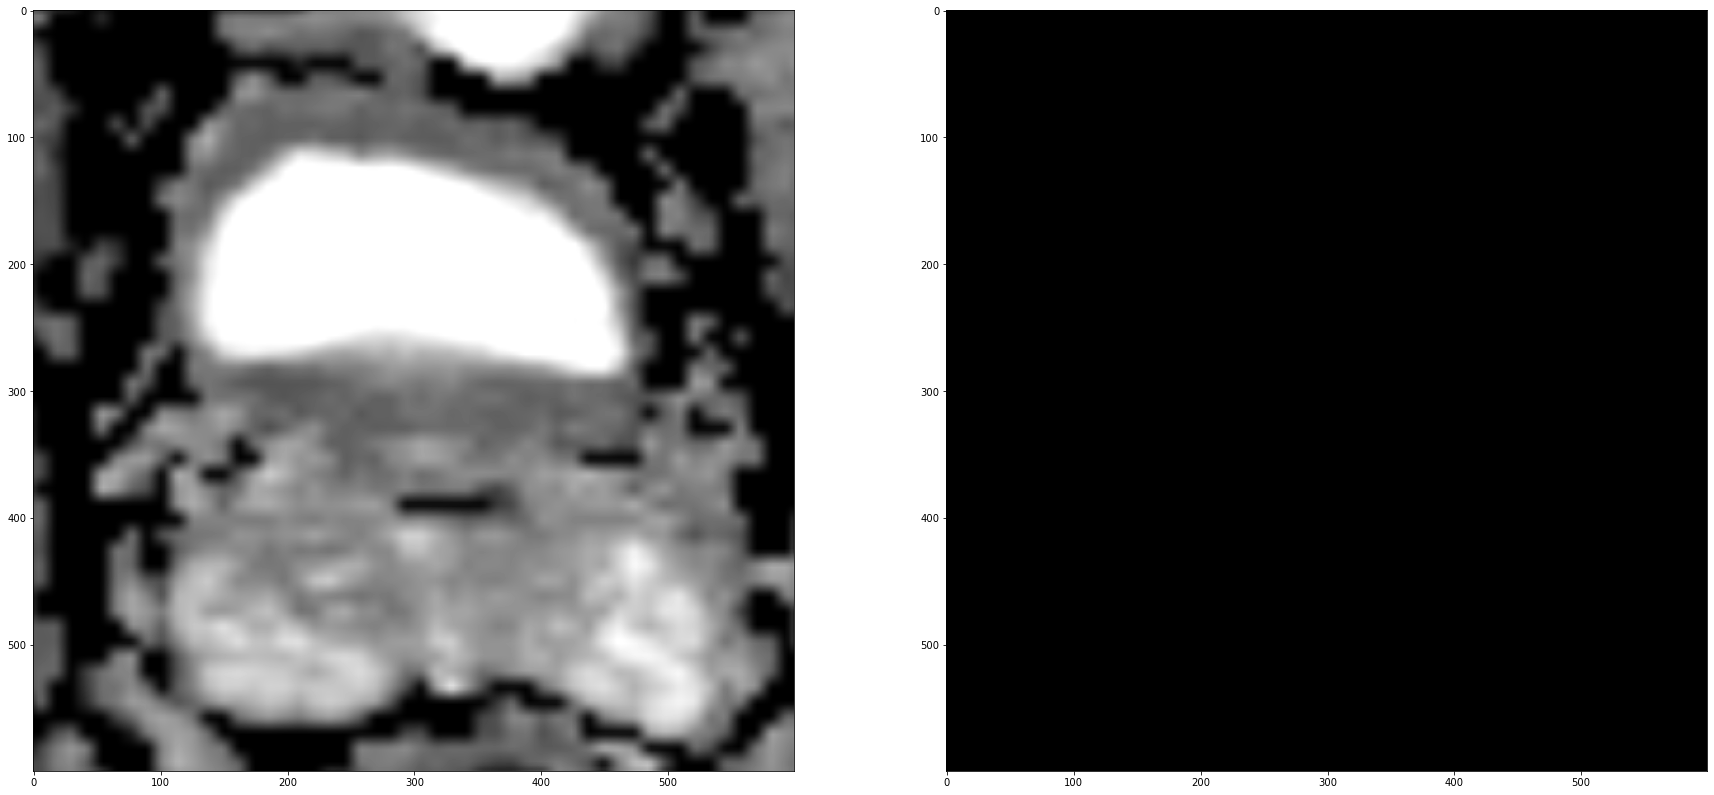

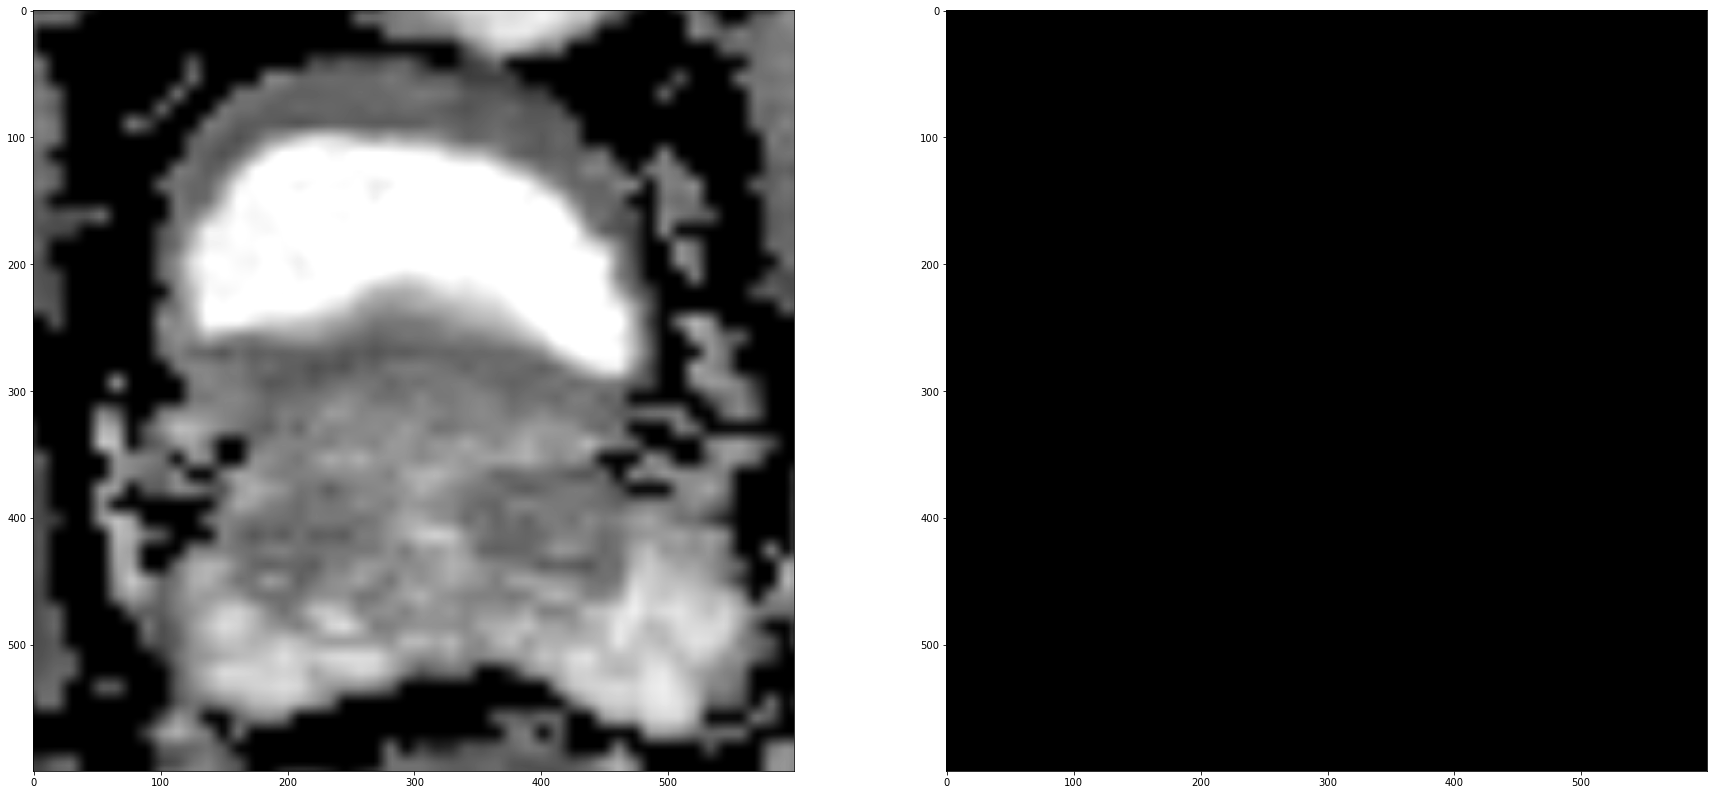

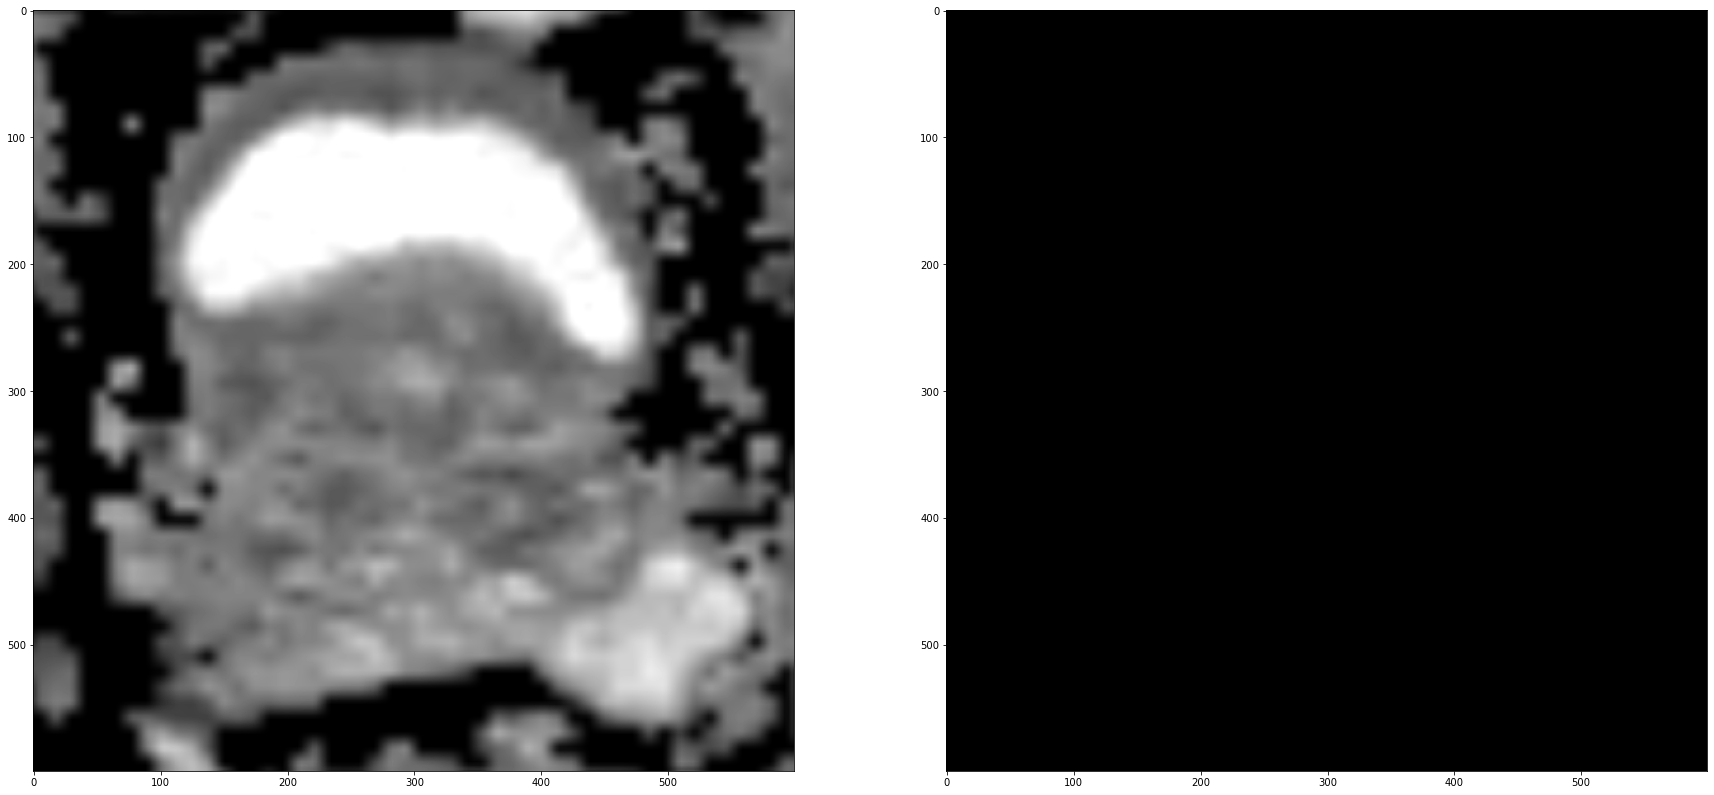

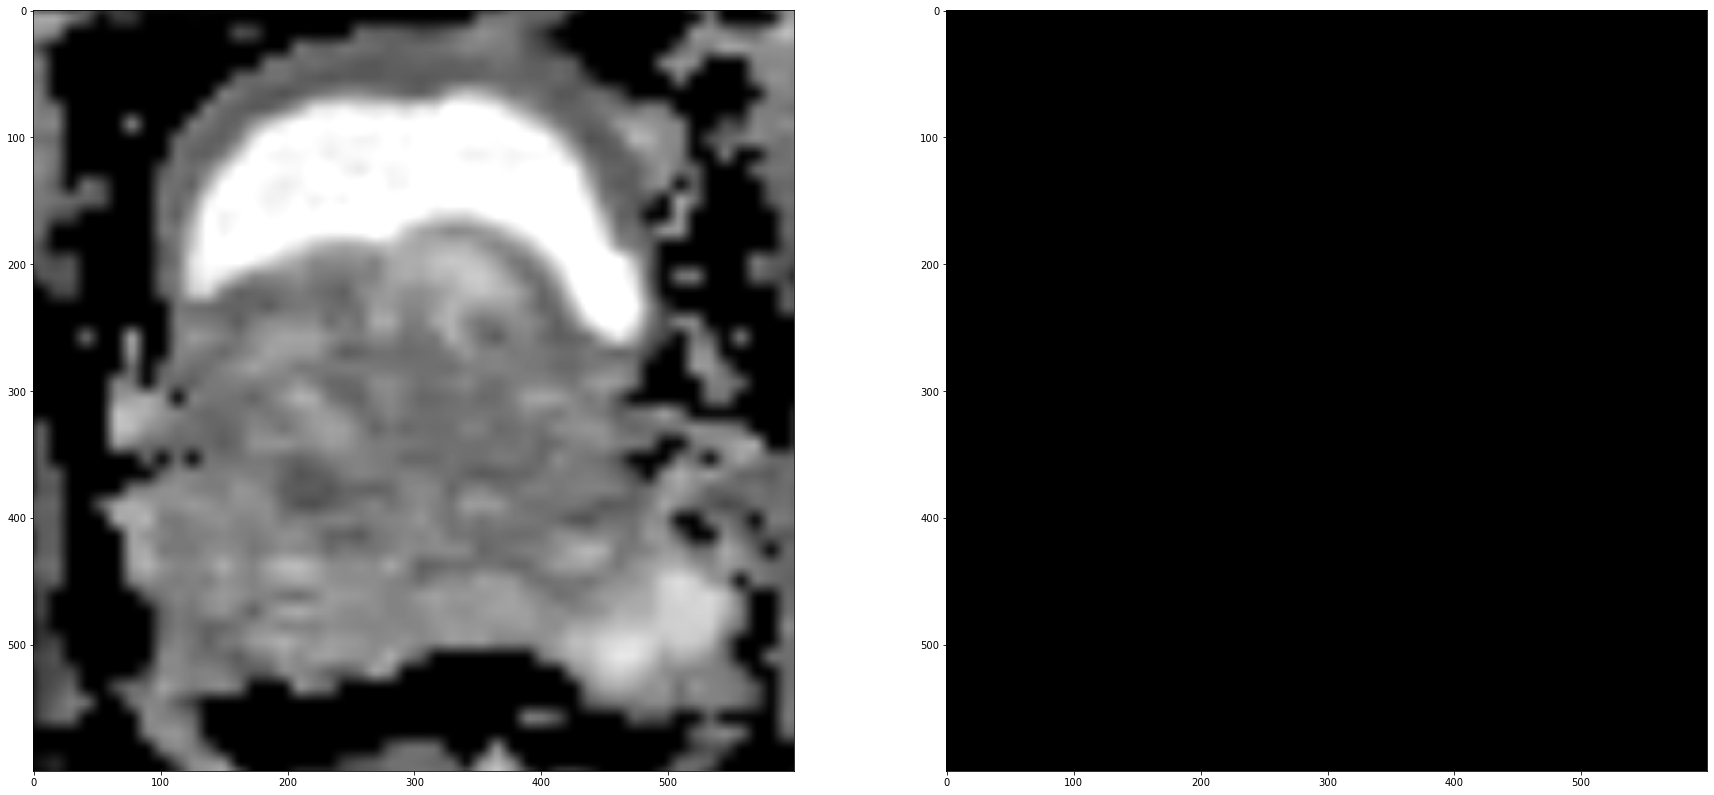

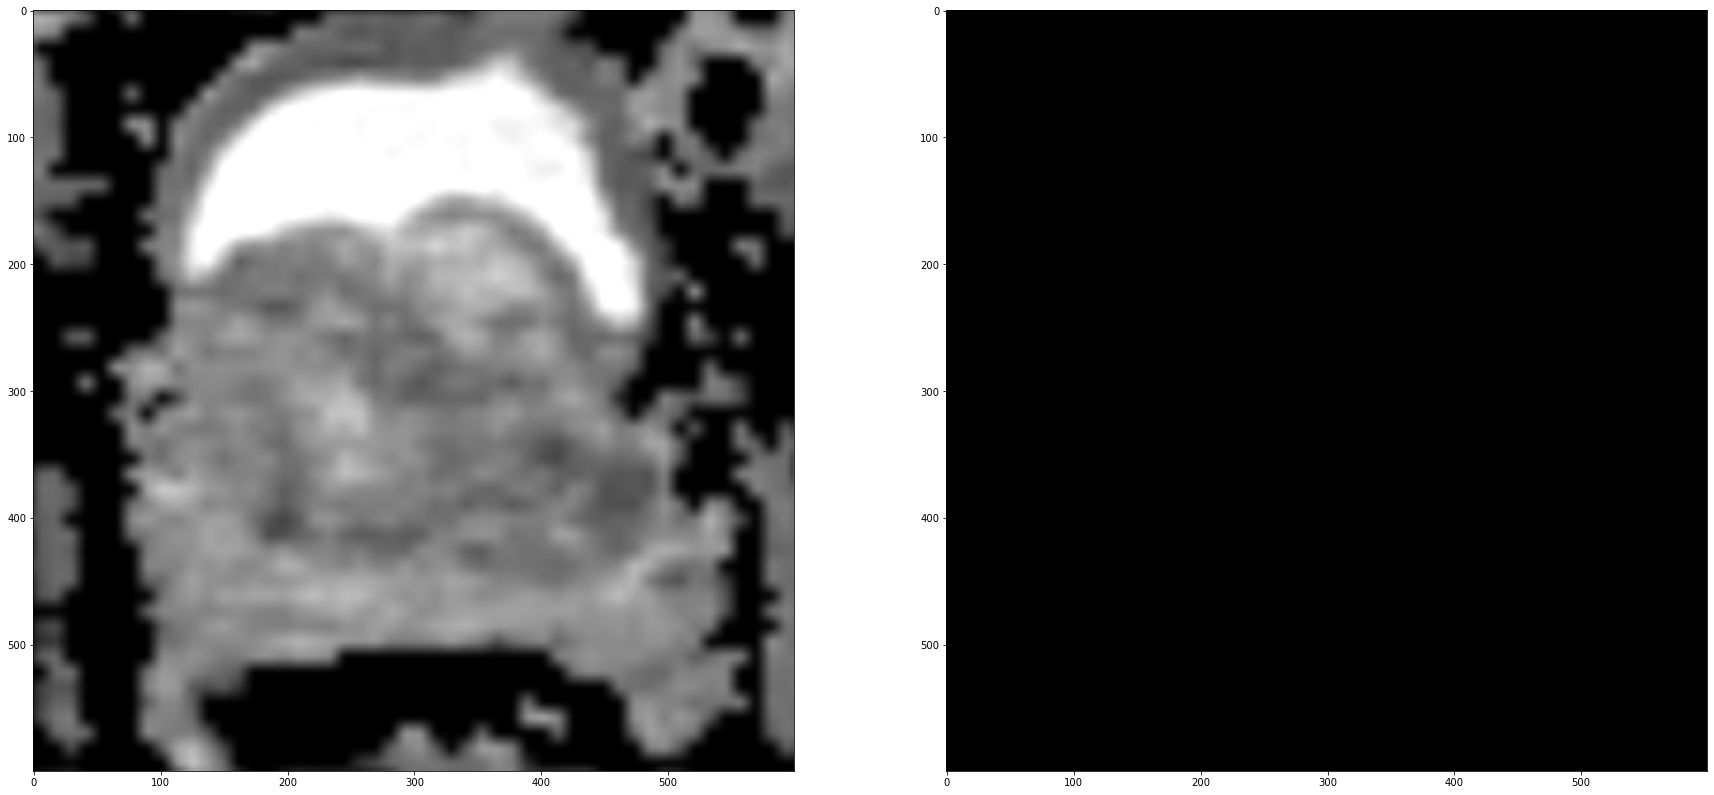

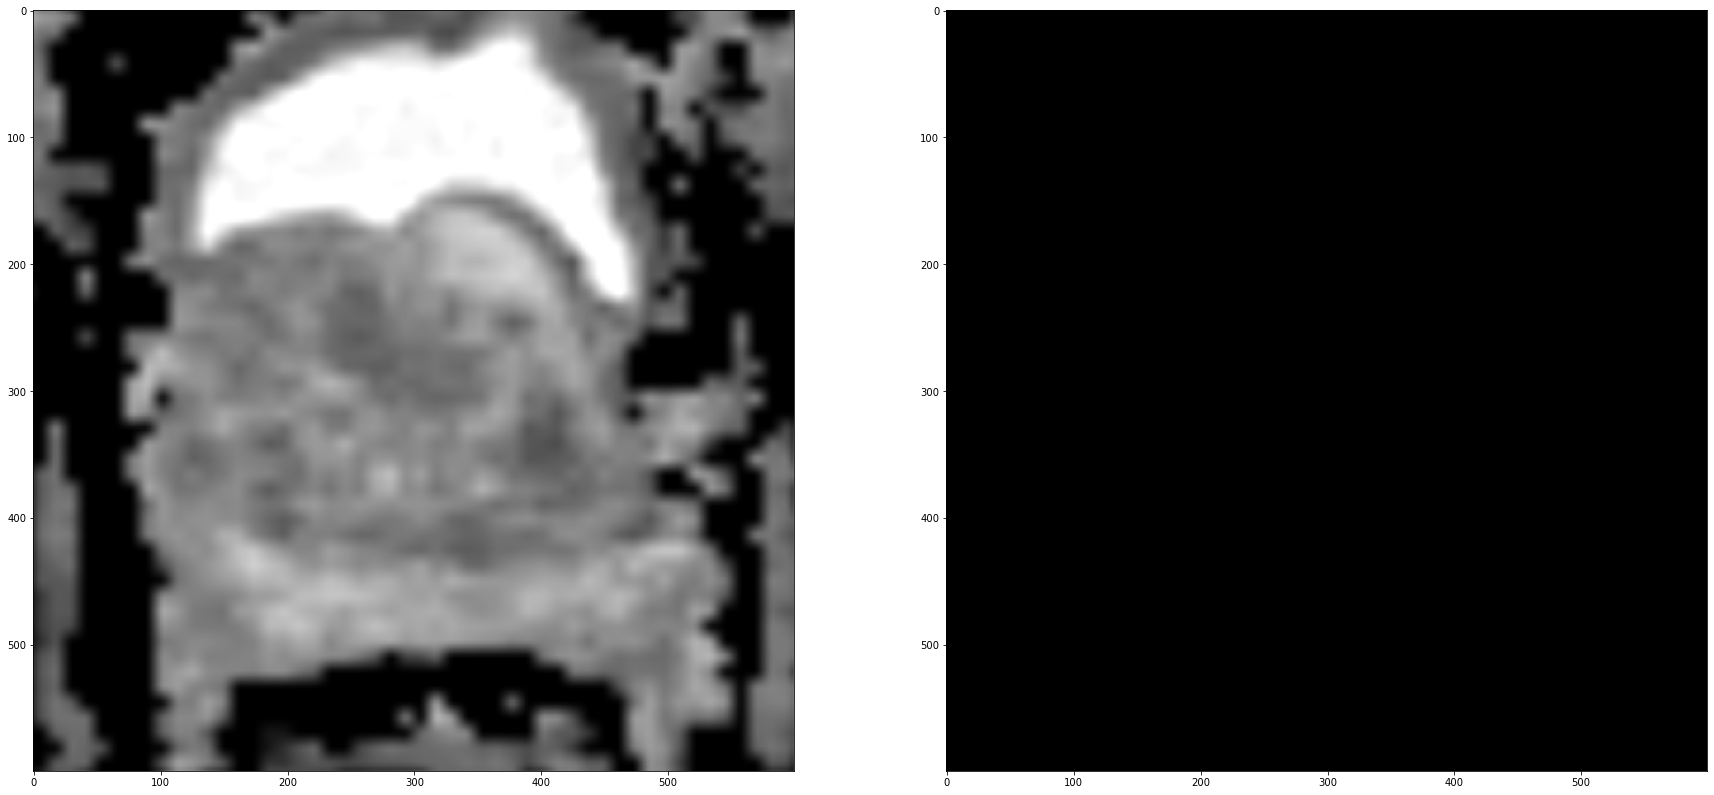

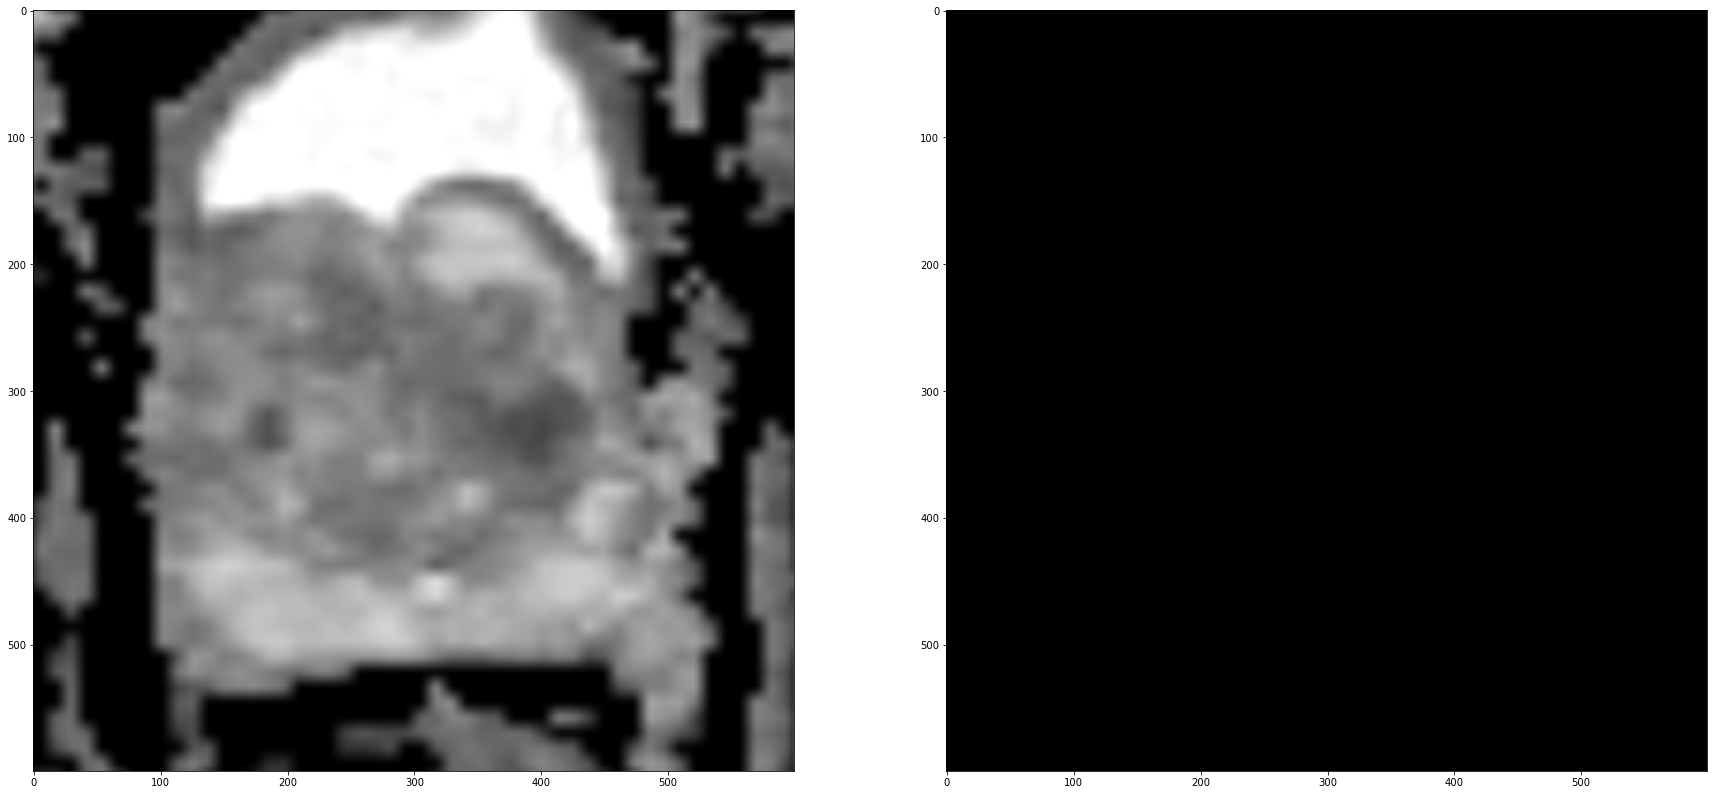

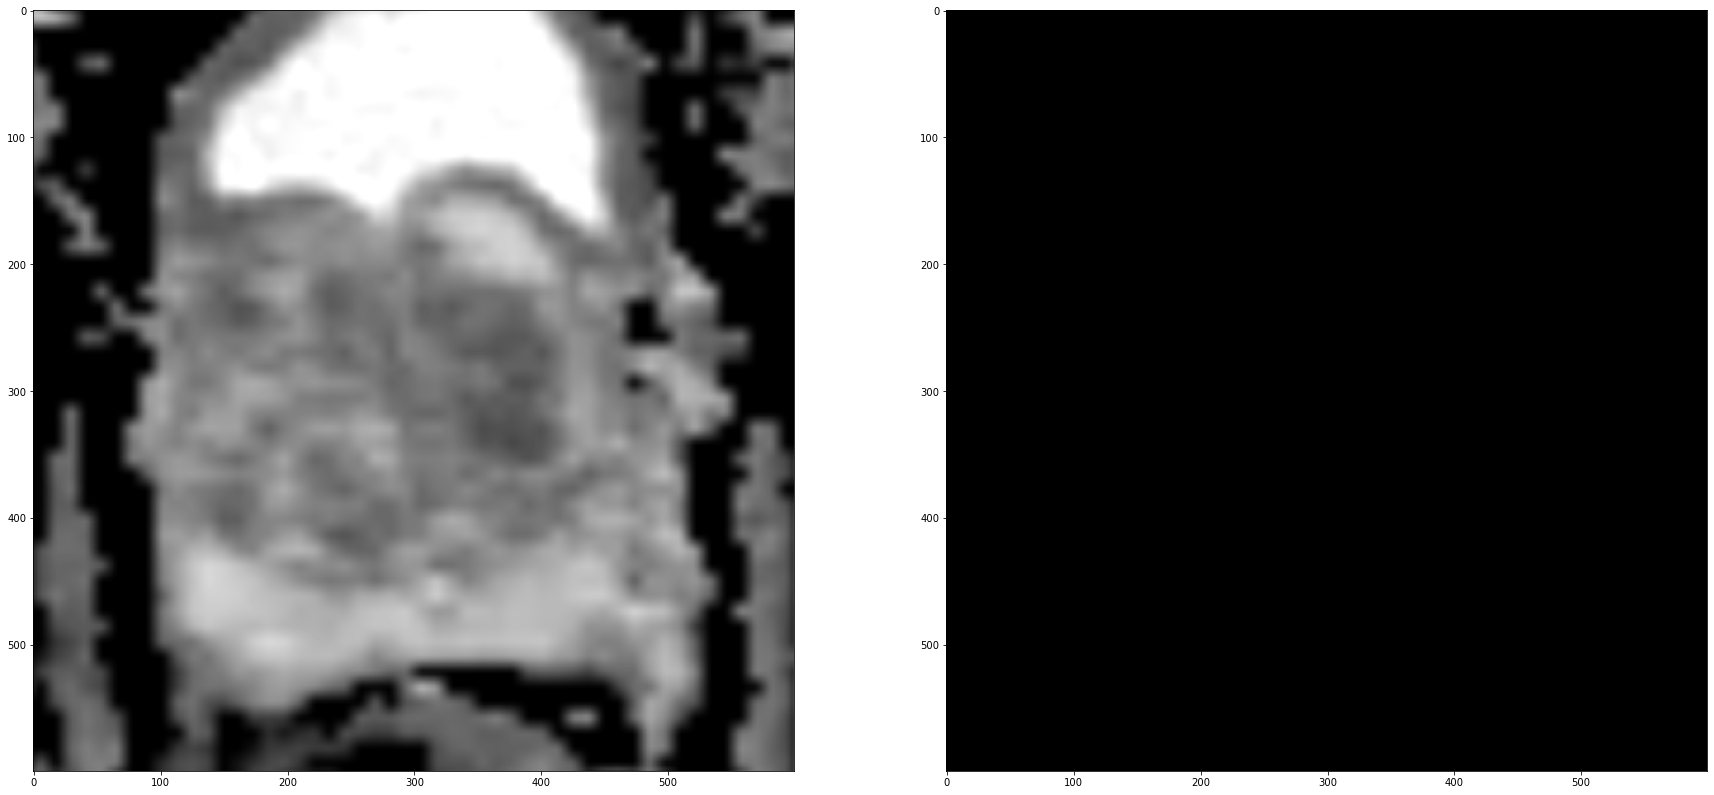

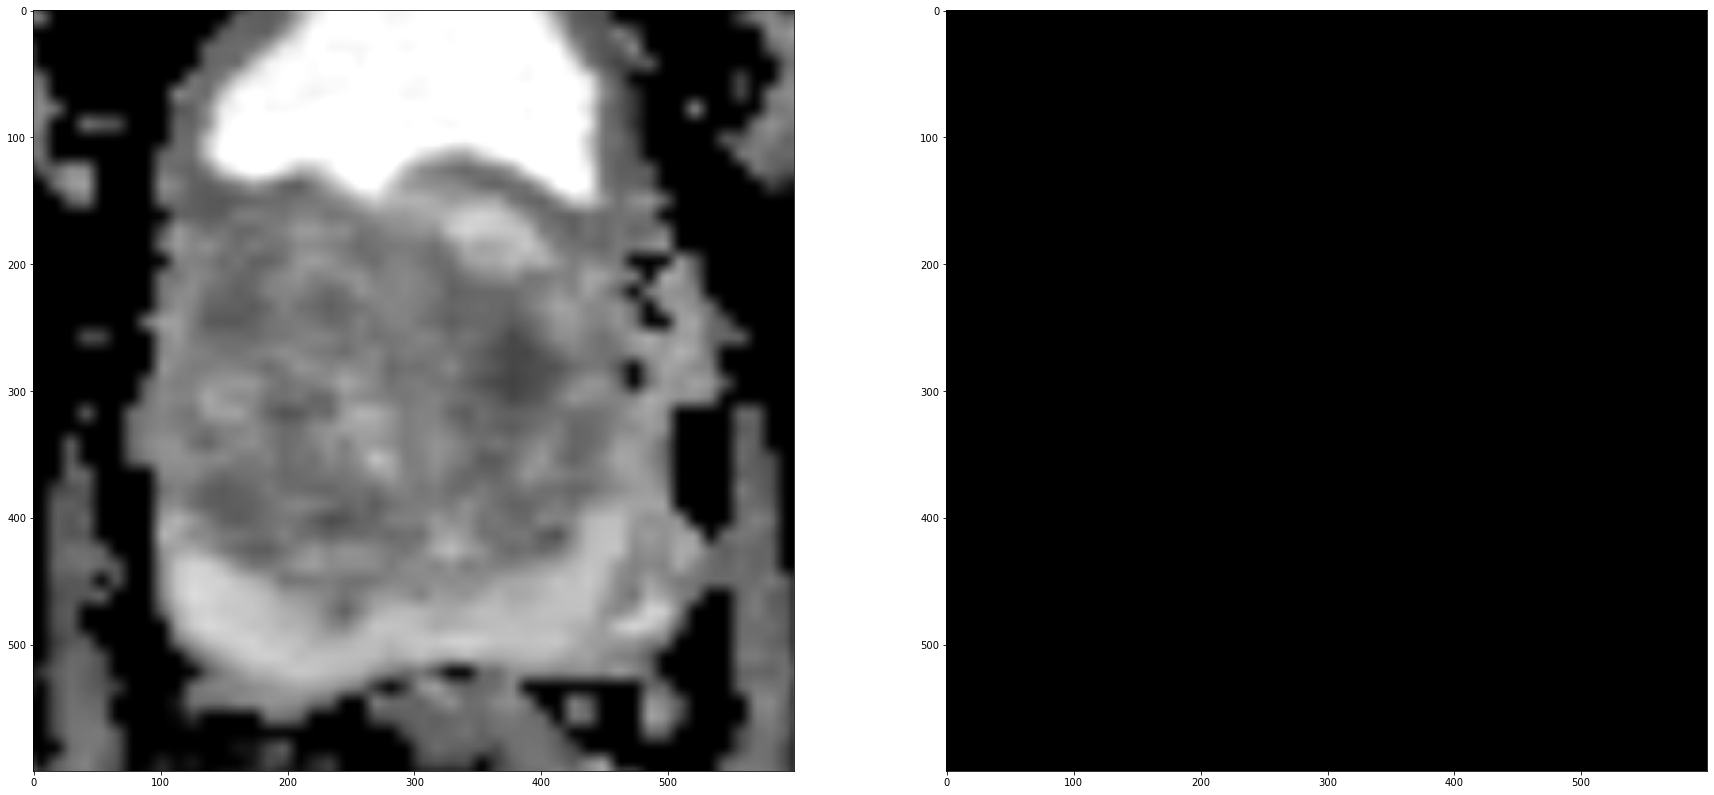

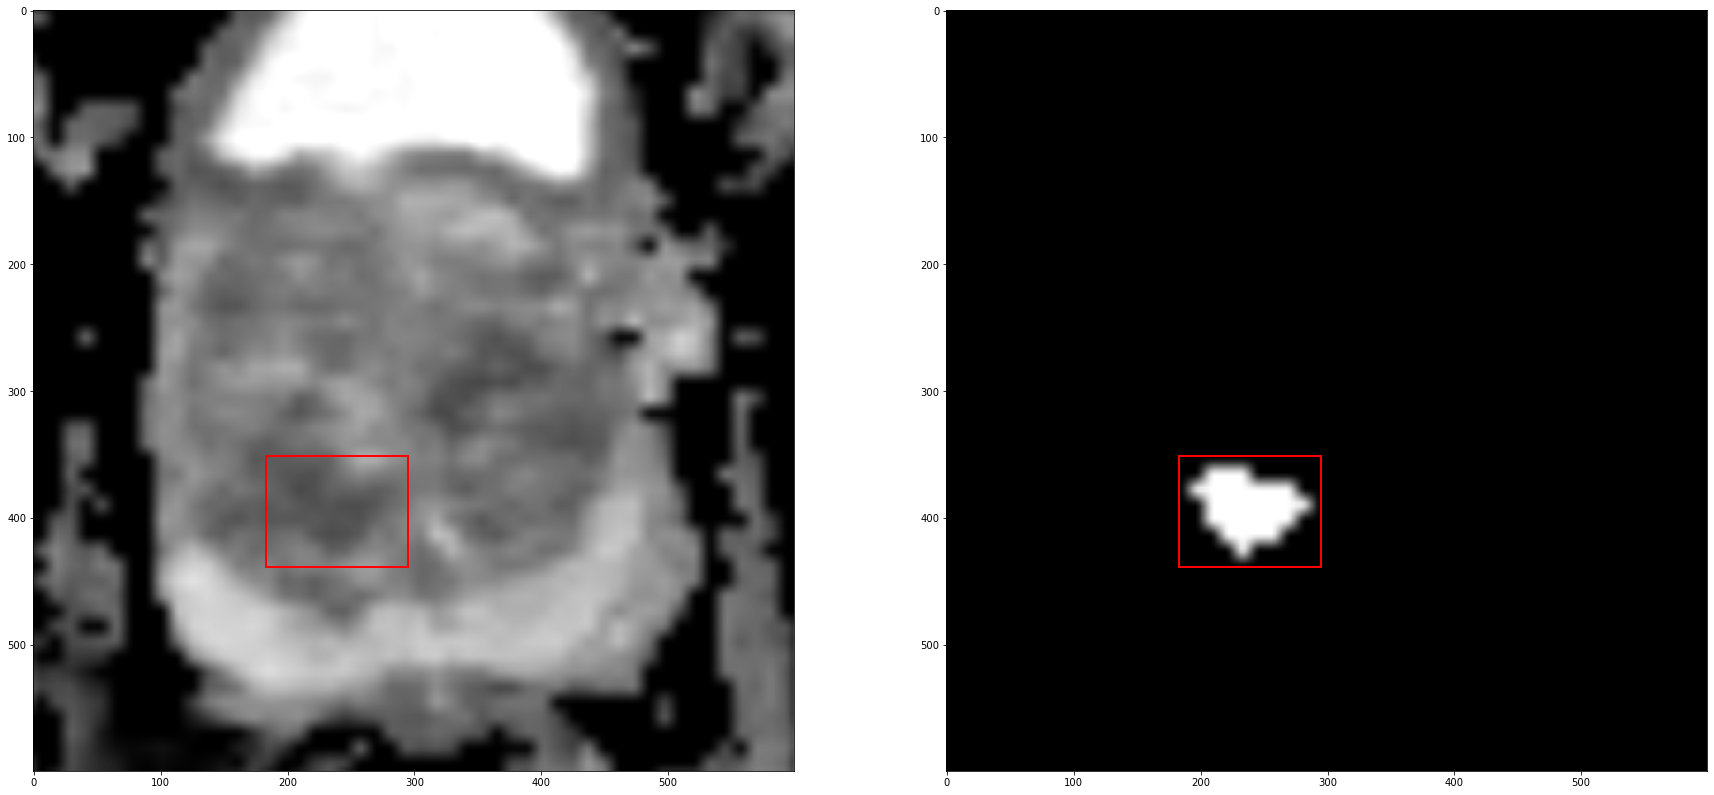

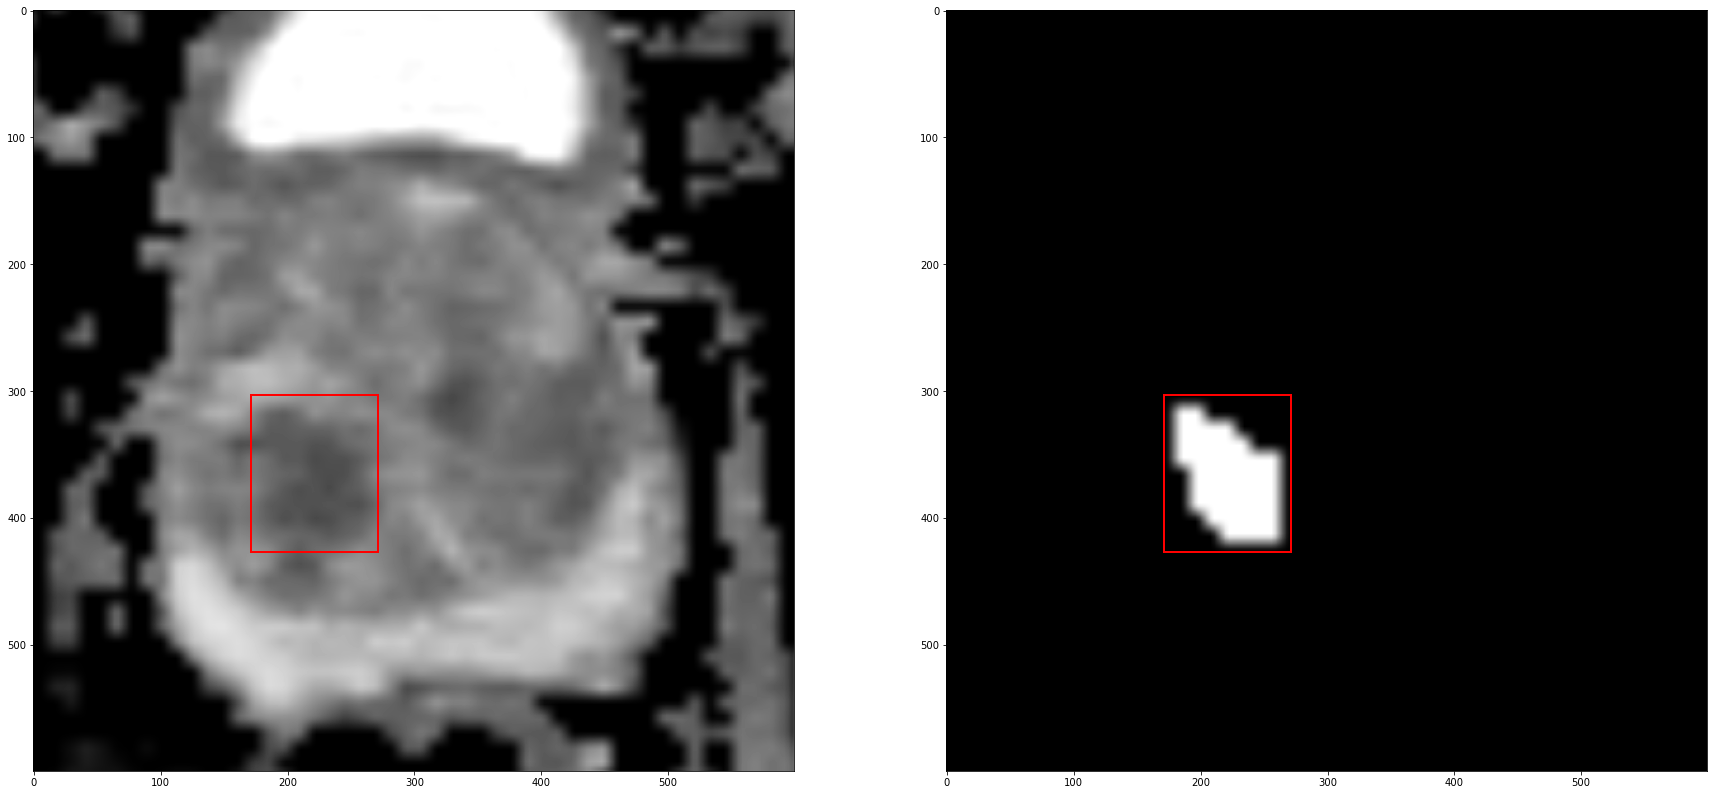

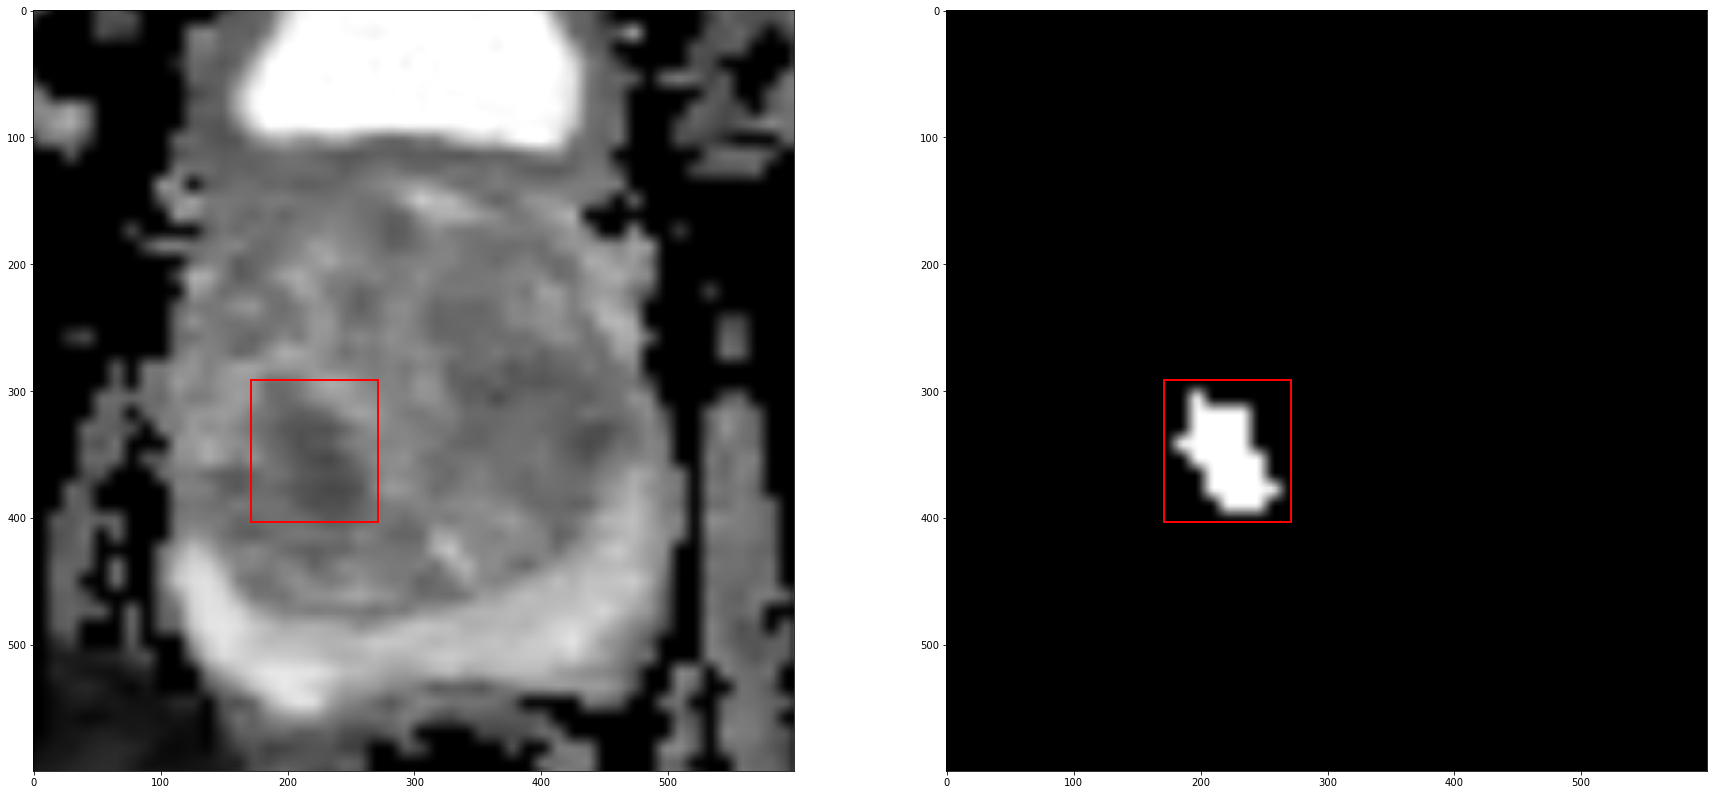

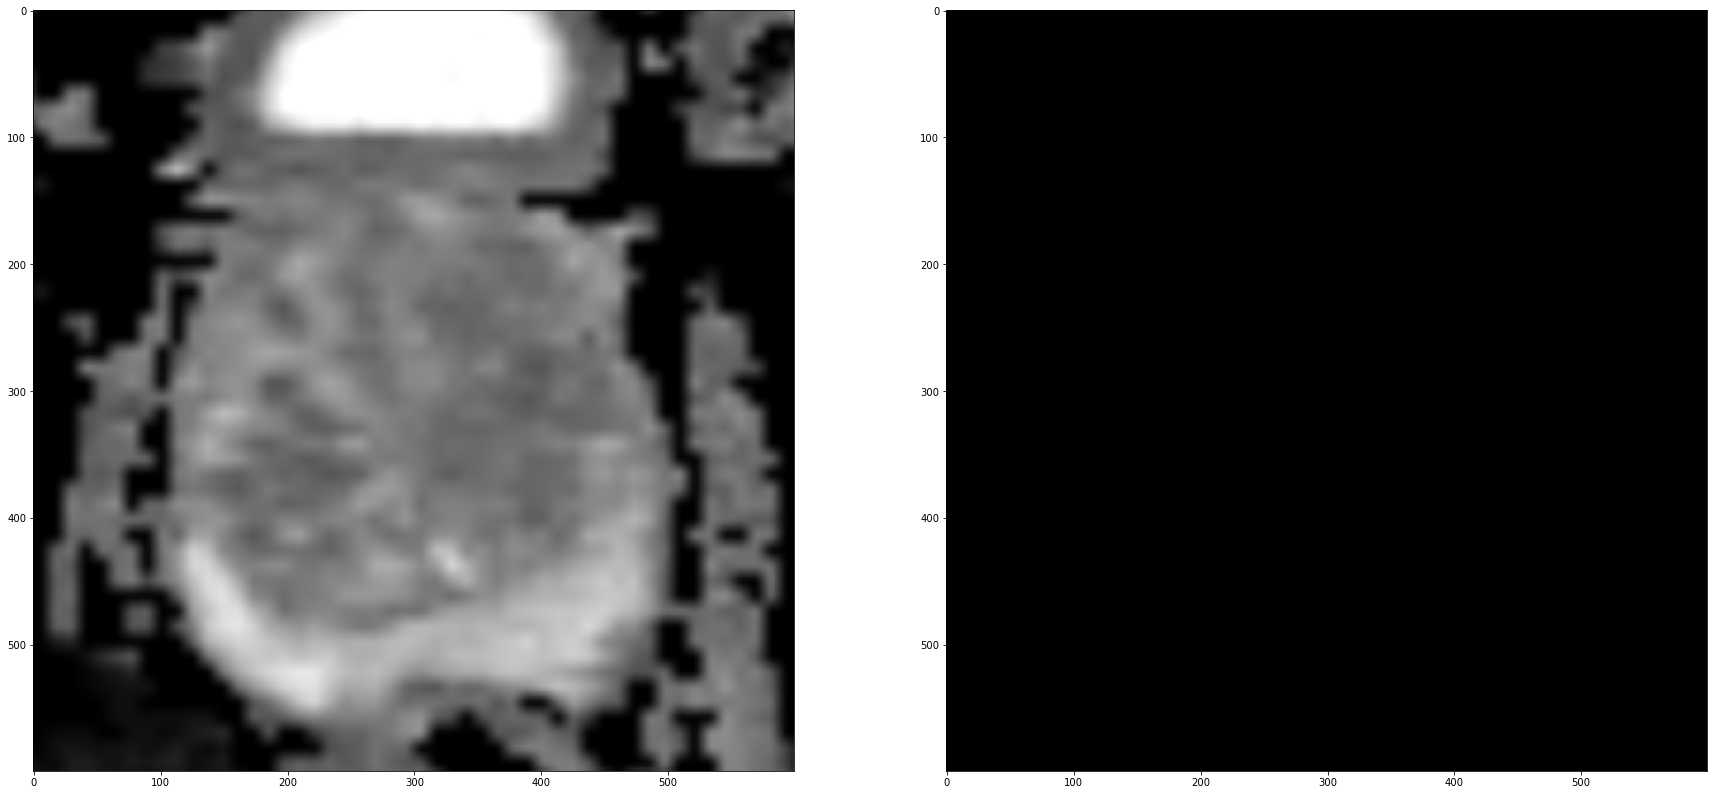

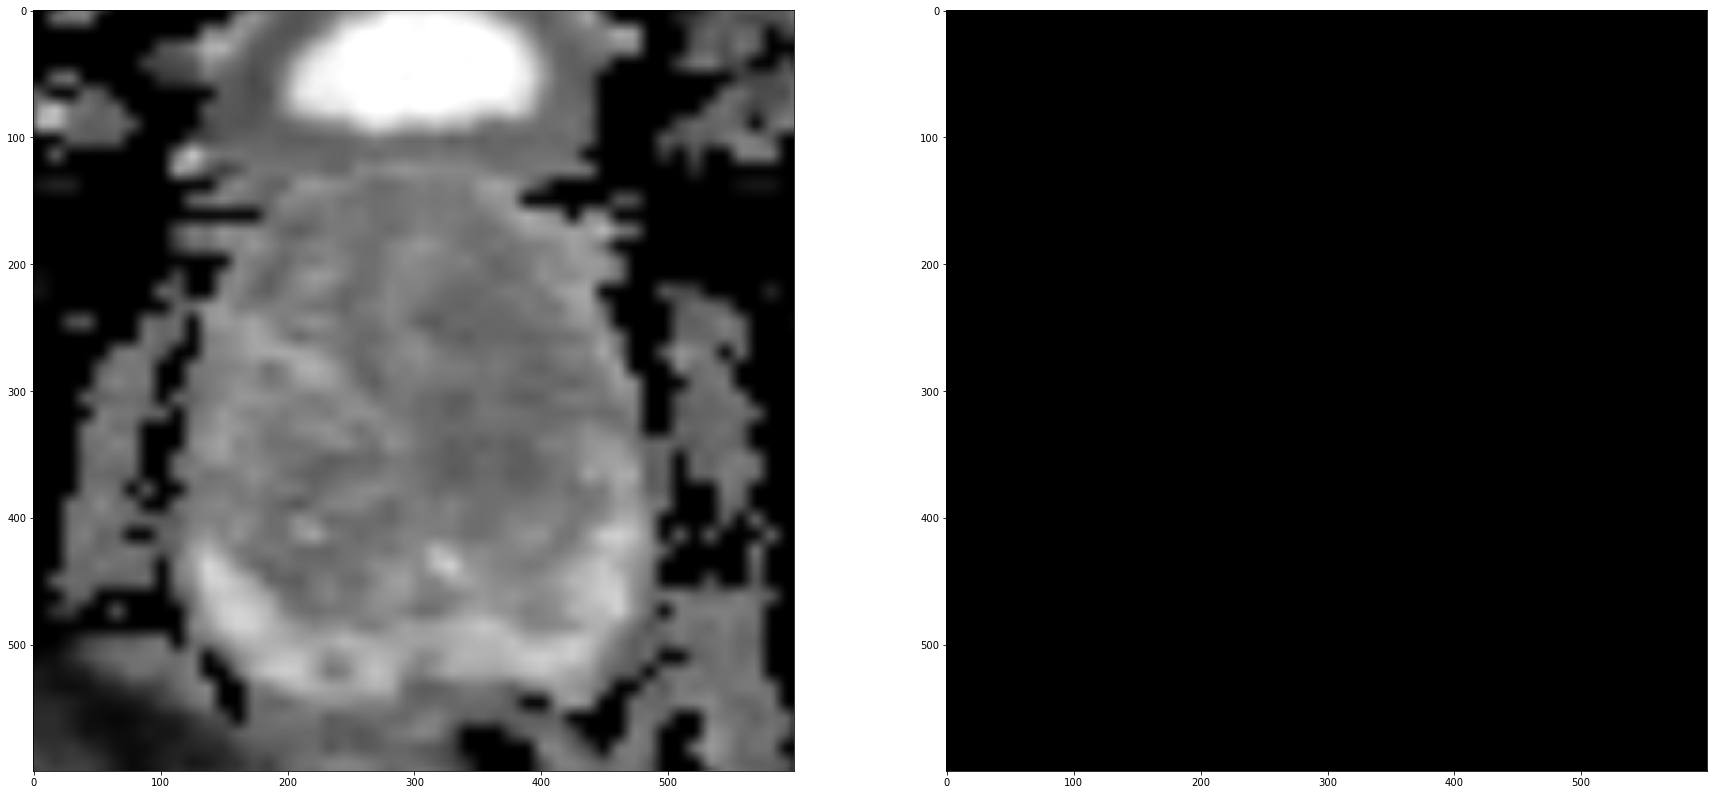

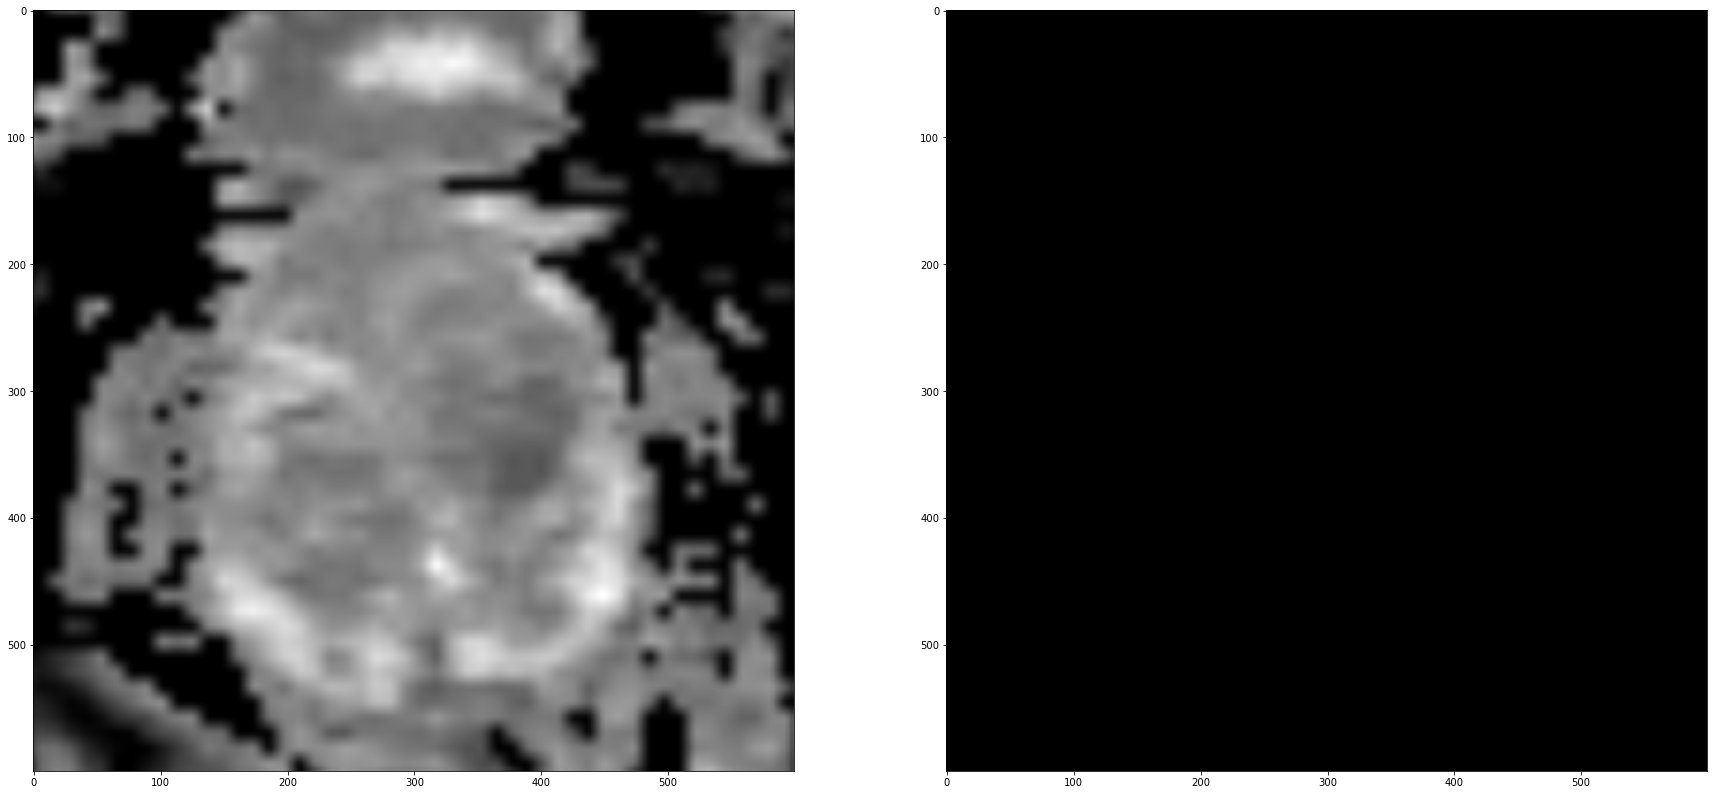

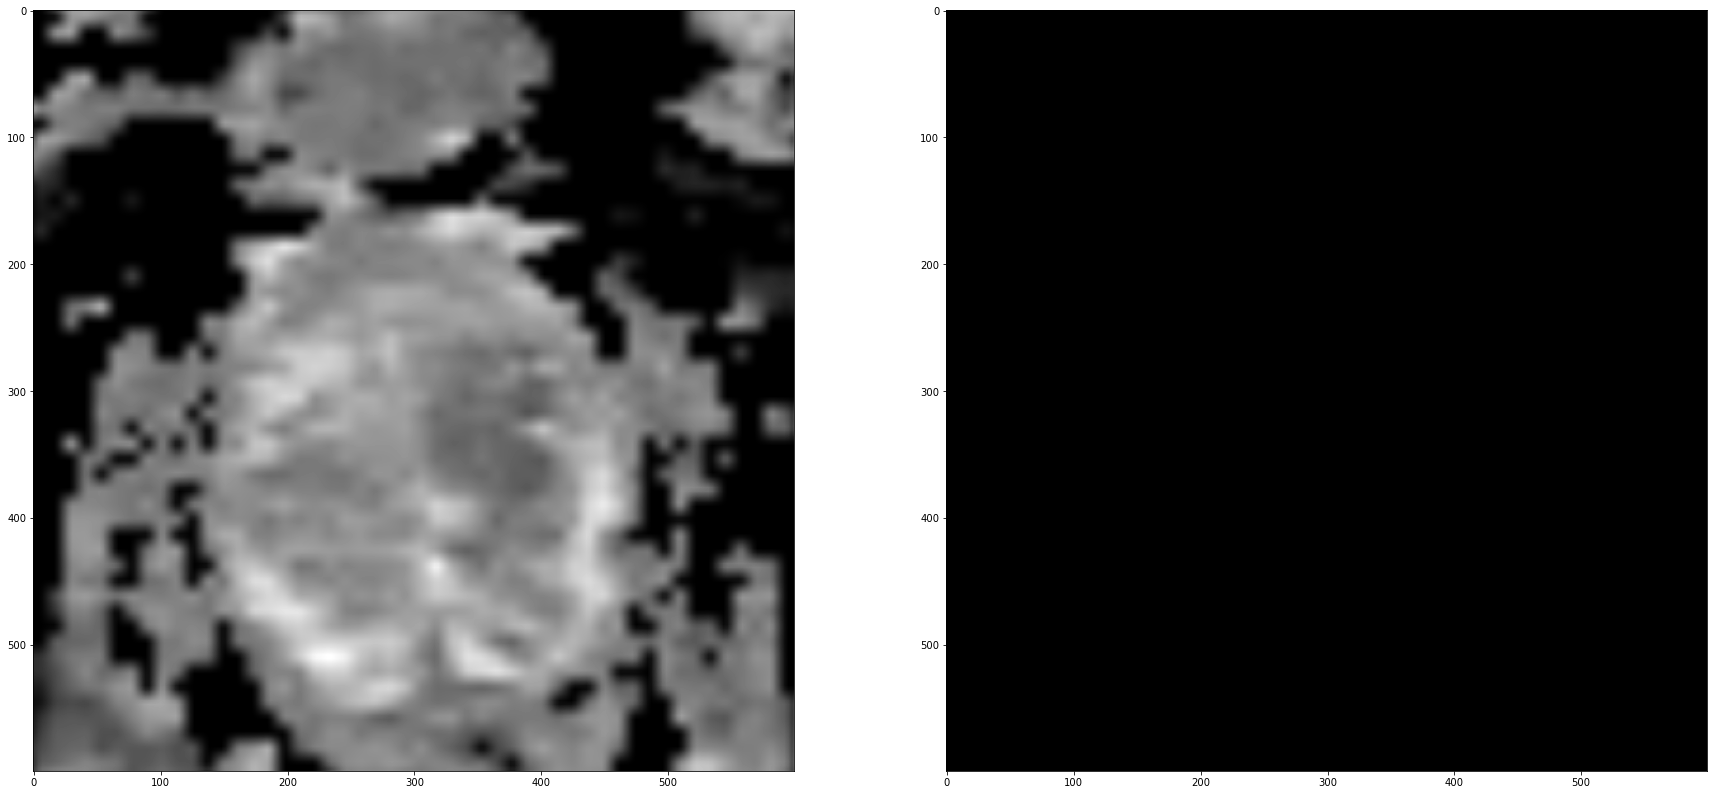

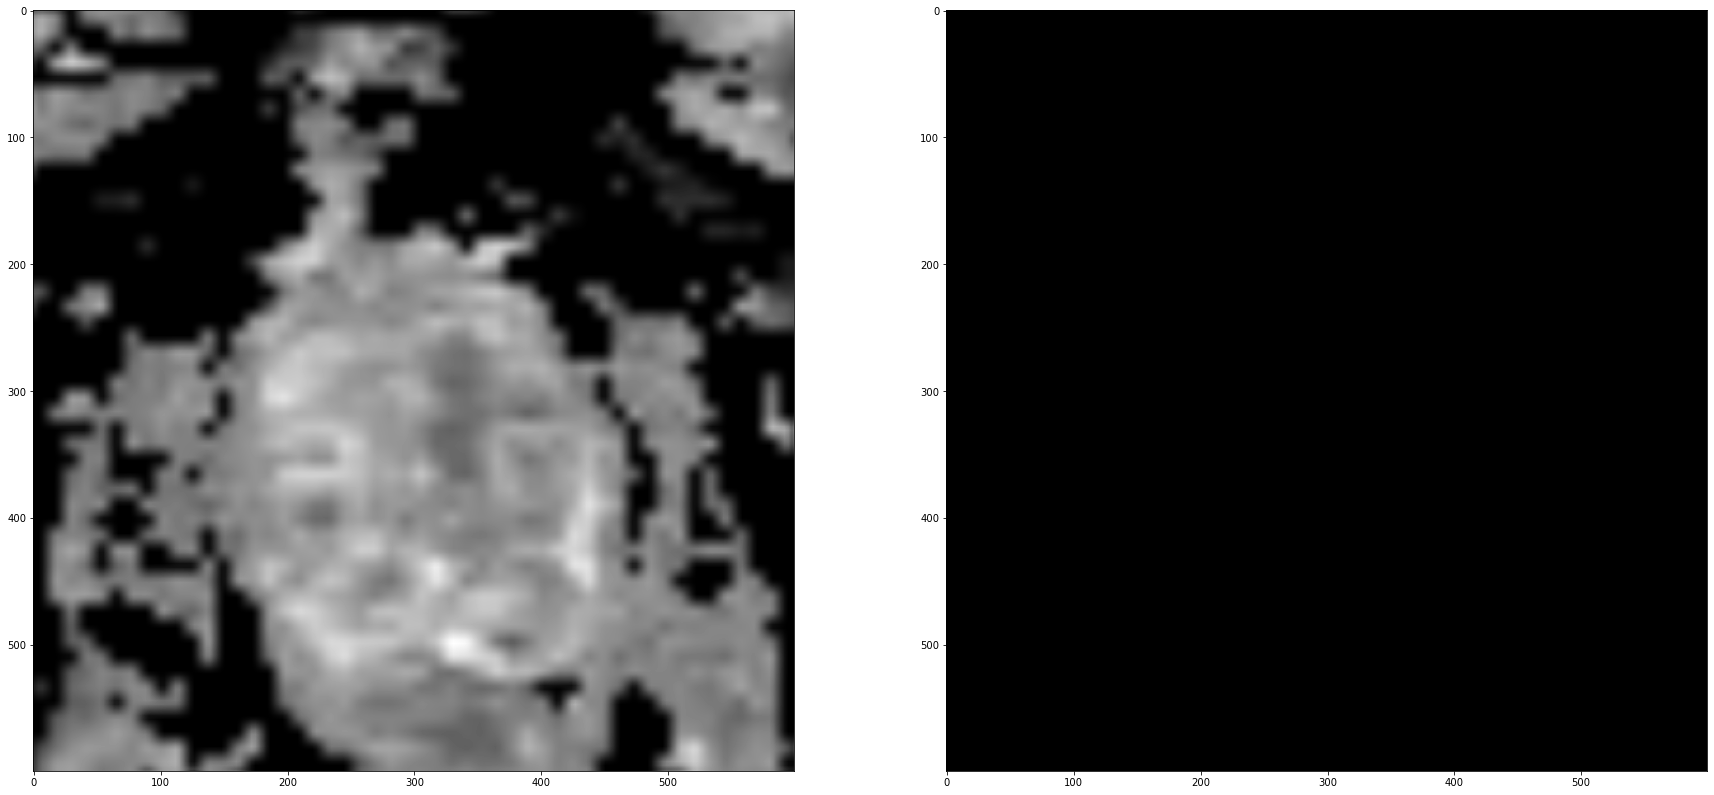

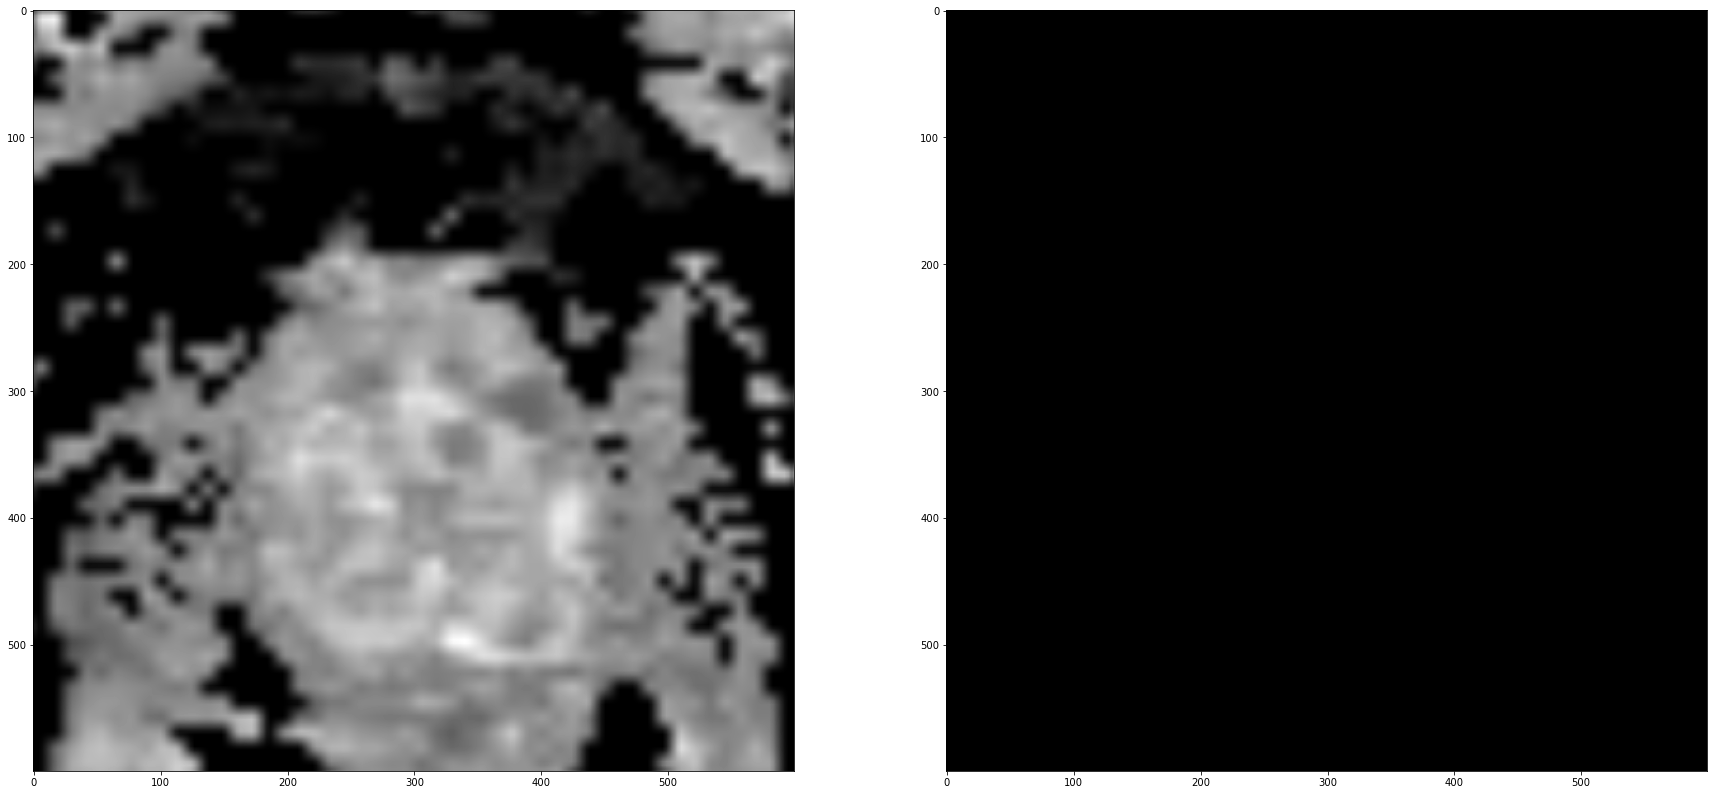

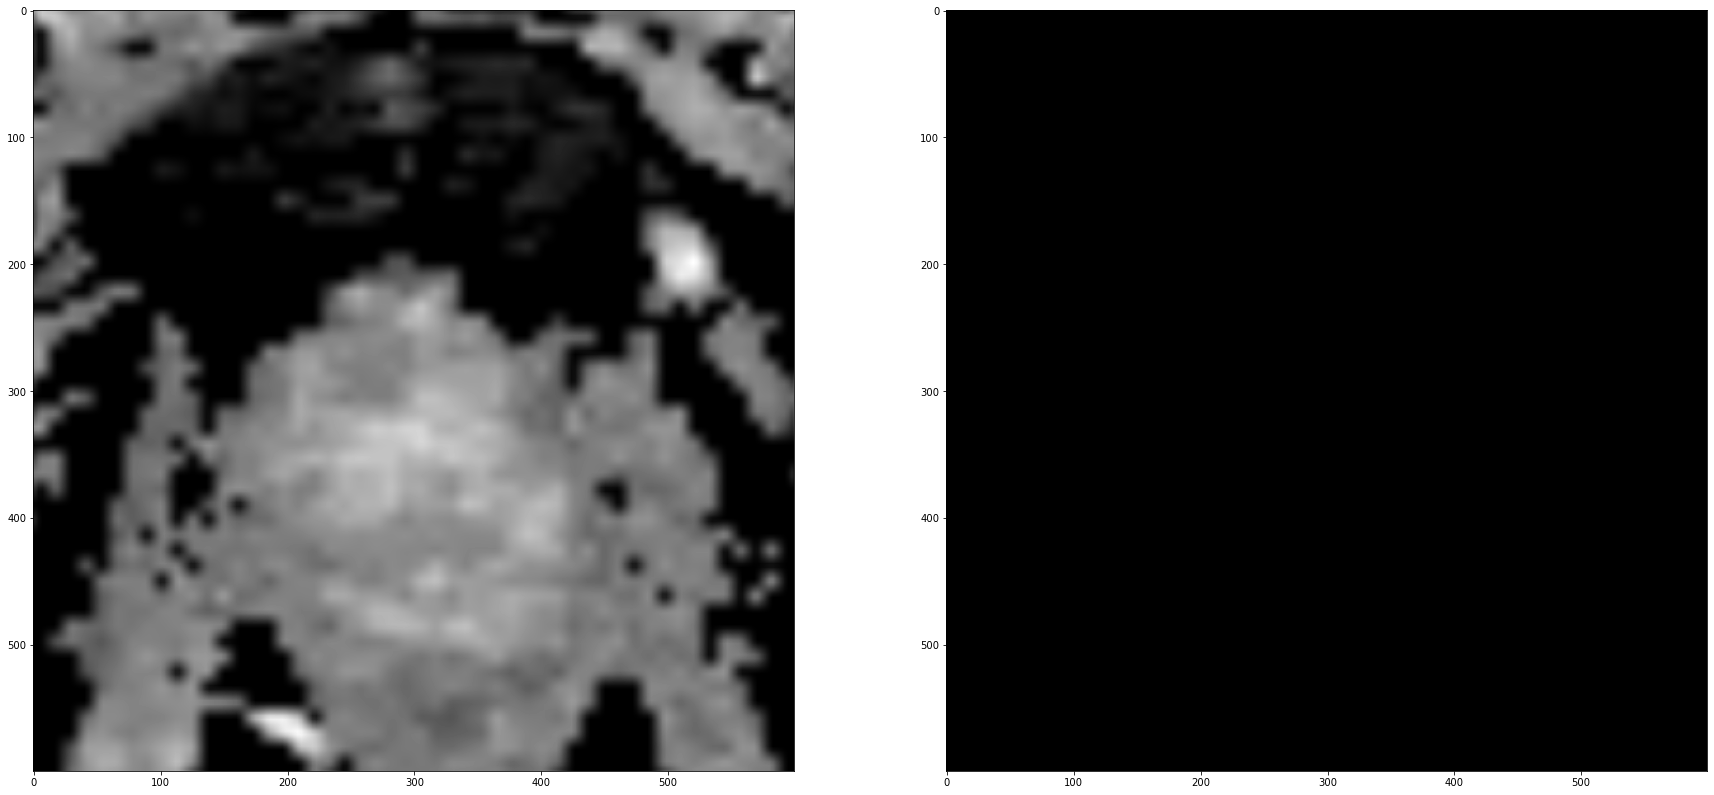

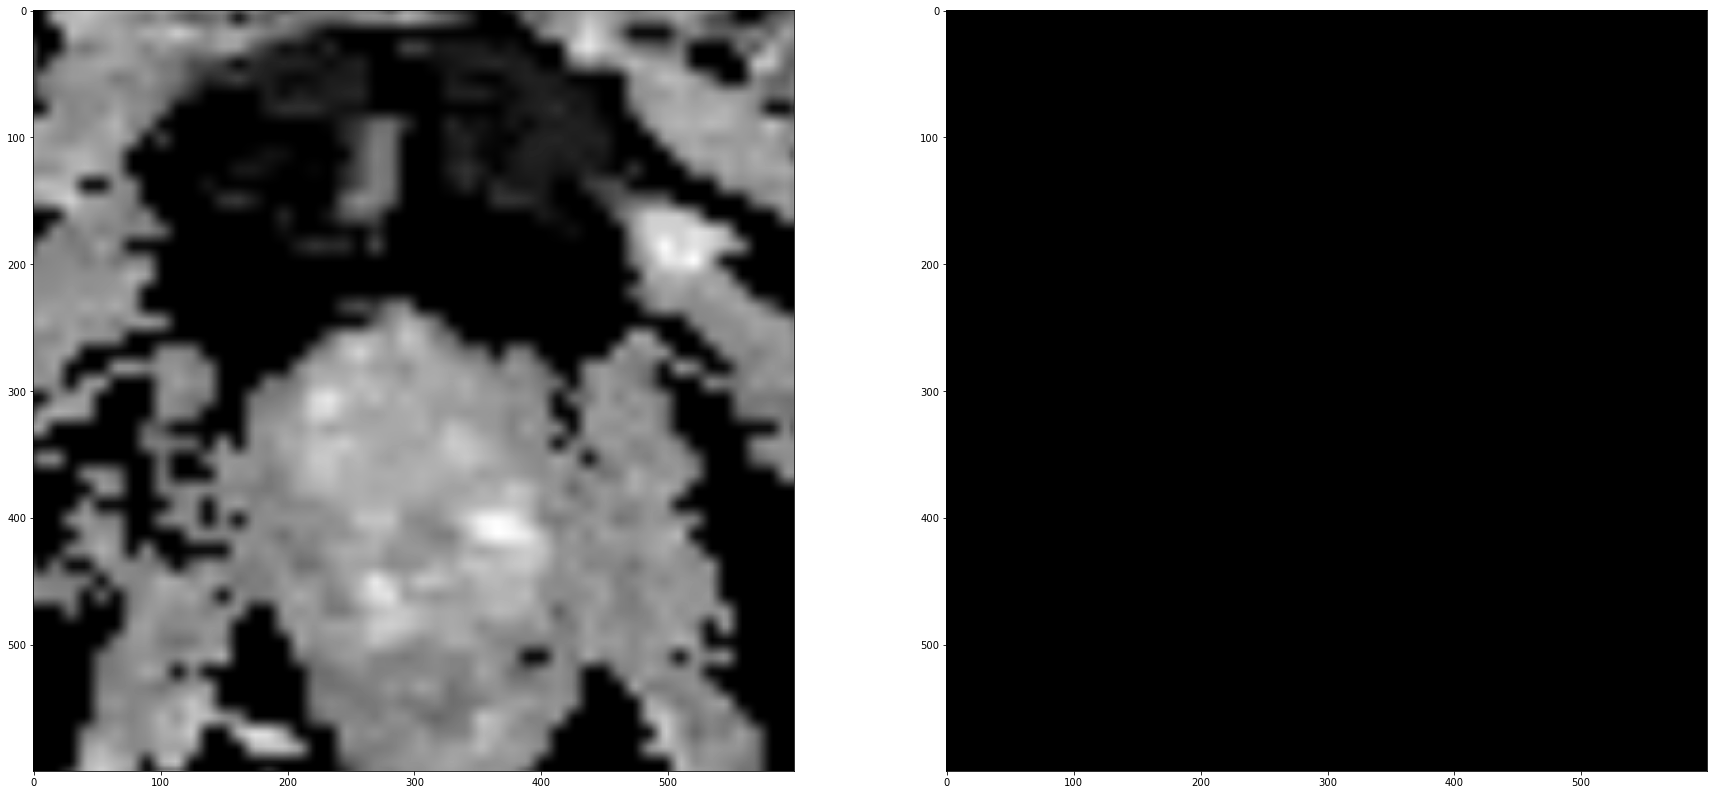

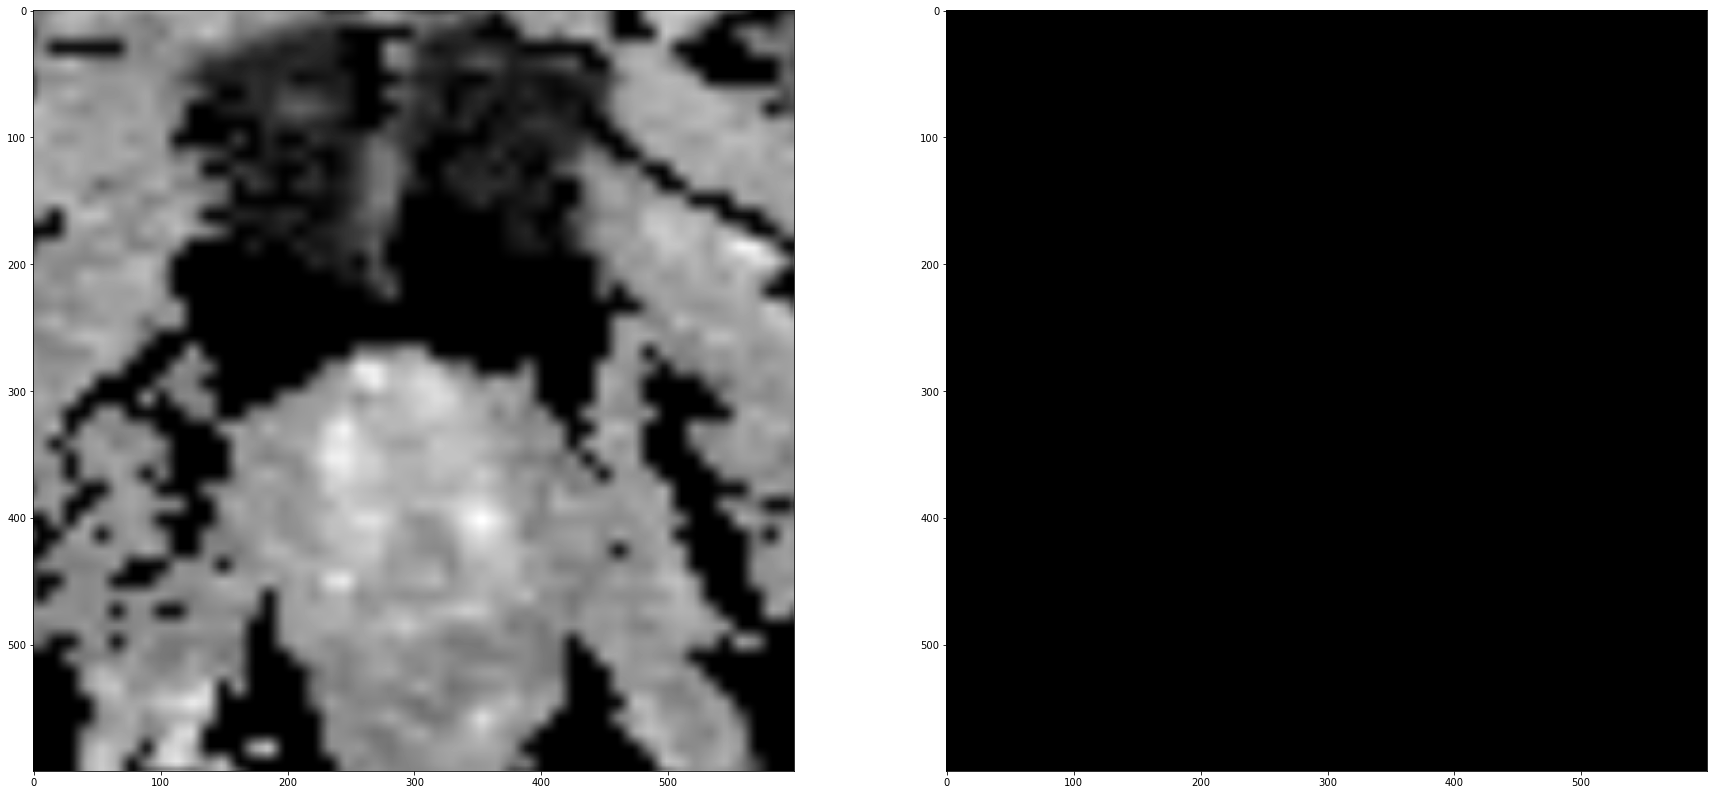

In [142]:
plot_data_mask_rev(normDicom_resiz,ArrayNifti_org[2])